# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#запрет на появление предупреждений
pd.options.mode.chained_assignment = None


In [2]:
n = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
n.head() #оценим содержимое датасета

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

По полученной информации о наборе данных можно сделать вывод, что часть из значений содержит пропуски, которые необходимо будет обработать. Часть из данных были определены таким типом, как object. Это данные о дате размещения объявления(необходимо перевести в формат date-time), сведения о том, апартаменты ли это(по описанию датасета столбец is_apartment должен иметь тип bool, стоит обратить внимание на его обработку), а также наименование населенного пункта.
Стоит отметить, что данные о числе этажей в здании, этаже-расположении квартиры, числе парков и прудов рядом должны быть типа  int, так как дробными описываемые параметры не бывают в природе (хотя в Санкт-Петербурге возможно все). Также типа int должны быть данные о сроке размещения объявления.

Далее оценим распределение полученных числовых данных используя метод гистограмм.

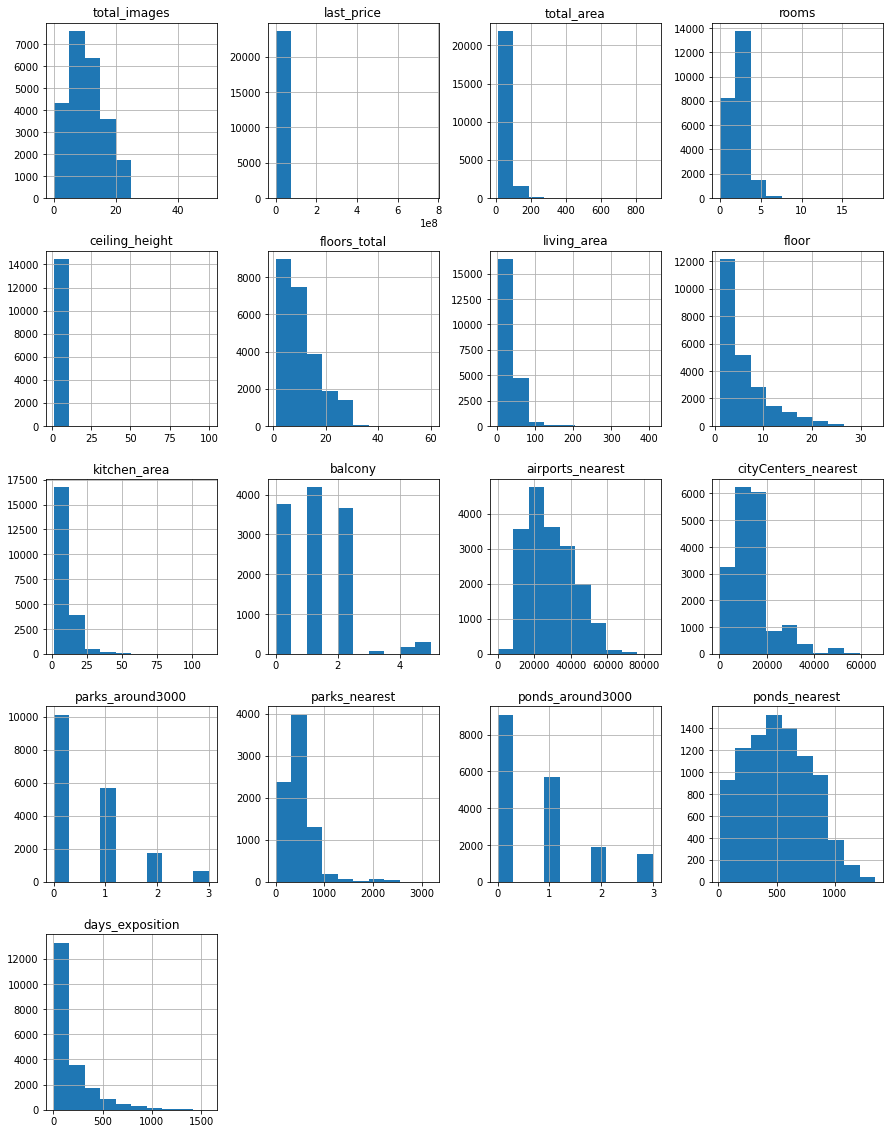

In [5]:
ax = n.hist(figsize=(15, 20))

Рассмотрим полученные гистограммы.
Количество фотографий в объявлениях не вызывает вопросов, хотя иногда их слишком много. По остальным данным необходима более точная оценка для формирования итоговых выводов.

### Предобработка данных

Приступим к предобработке данных. 
Необходимо привести все данные в нужный формат, обработать пропуски, предварительно обнаружив места их расположения, обработать дубликаты и выбросы.

In [6]:
n.isna().sum() #оценим число пропусков в каждом из столбцов

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Выводы по результатам оценки пропусков и возможные стратегии заполнения:

1) достаточно много пропущенных значений в столбце is_apartment, возможно, этот параметр в описании жилья появился не с начала ведения базы данных о квартирах или же не являлся обязательным при заполнении карточки объекта, поэтому, если автор объявления не указал, что продает апартаменты, то можно сделать вывод, что объект недвижимости им не является;
2) для строк с пропущенным числом этажей в здании и названием локации в качестве метода обработки пропусков допустимо удаление, так как число строк суммарно менее 5% от полученного датасета и репрезентативность выборки останется на уровне;
3) расстояние до ближайшего аэропорта заменим медианным значением расстояния от аэропорта для каждого из населенных пунктов, аналогично поступим и с расстоянием до центра города;
4) для обработки строк с пропусками в столбцах с высотой потолков и площадью кухни применим медиану, так как в среднем квартиры по населенным пунктам строились по типовым планам и не должны разительно отличаться друг от друга;
5) при заполнении пропусков в общей жилой площади будем использовать сведения о том, какой процент от общей площади обычно занимает жилая. Долю жилой площади получим, исходя из заполненных значений;
6) примем, что если в объявлении пропущены сведения о наличии балкона, прудах и парках в радиусе 3 км, то этого всего и нет, так как иначе автор объявления бы указал важный факт в описании объекта, то есть, возможно заполнить пропуски нулевым значением;
7) срок размещения объявления, расстояние до водоемов и парков оставим без обработки, так как эти данные заполнялись в автоматическом режиме и корректно оценить, каким параметром заполнить пропущенные значения невозможно.

Так как часть пропусков будут заполняться медианными значениями, перед началом работы стоит оценить выбросы и обработать их, чтобы не получить негативный эффект для качества данных при заполнении пропусков.



In [7]:
#форматирование столбца с датой размещения в формат дата-время
n['first_day_exposition'] = pd.to_datetime(n['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [8]:
#обработка пропусков в названии населенного пункта и числе этажей
n=n.dropna(subset=['floors_total', 'locality_name'])


In [9]:
#оценим высоту потолков по выборке
n['ceiling_height'].describe()
#для многоквартирного дома высота потолка по нормам выше 2,5 м и обычно не превышает 5 м

count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [12]:
#заменим значения менее 2,5 м на минимально допустимые 2,5м
n['ceiling_height'].loc[n['ceiling_height'] < 2.5] = 2.5


In [13]:
n.loc[n['ceiling_height'] > 5, 'ceiling_height'].value_counts() #оценка числа квартир с аномально высокими потолками

27.0     8
25.0     7
8.0      3
5.3      2
32.0     2
14.0     1
5.2      1
6.0      1
8.3      1
5.6      1
5.8      1
10.3     1
5.5      1
20.0     1
26.0     1
22.6     1
27.5     1
24.0     1
100.0    1
Name: ceiling_height, dtype: int64

Как мы видим, часть квартир имеют высоту потолков 25-32 метра, скорее всего, автор объявления при вводе значений ошибся и забыл запятую при указании дробной части. Такие записи следует обработать, уменьшив значения в 10 раз. Иные значения высоты потолков можно удалить, так как их немного, а оценить реальную высоту потолка значительно проблематично.

In [14]:
n.loc[((n['ceiling_height'] > 24) & (n['ceiling_height'] <33)), 'ceiling_height'] *= 0.1 
n['ceiling_height'] = n.loc[n['ceiling_height'] <= 5, 'ceiling_height'] #удаление выбросов
n.loc[n['ceiling_height'] > 5, 'ceiling_height'].value_counts()  #оценка качества уддаления выбросов

Series([], Name: ceiling_height, dtype: int64)

In [15]:
#заполним пропуски в значениях высоты потолков медианой 
for locality_name in n['locality_name'].unique():
    median_height = n.loc[n['locality_name']== locality_name, 'ceiling_height'].median()
    n.loc[(n['ceiling_height'].isna()) &
        (n['locality_name']== locality_name), 'ceiling_height'] = n.loc[(n['ceiling_height'].isna()) &
        (n['locality_name']== locality_name), 'ceiling_height'].fillna(median_height)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

In [16]:
#проверим результаты заполнения
n['ceiling_height'].isna().sum()

120

С потолками разобрались, движемся дальше

In [17]:
n['floors_total']=n['floors_total'].astype('int') #изменение типа данных в столбце с высотой дома

In [18]:
n['is_apartment'] = n['is_apartment'].fillna(False).astype('bool')
n['is_apartment'].isna().sum() #проверим результаты заполнения

0

In [19]:
#заполнение пропусков в строках о наличии балкона, водоемов и парков рядом
columns = ['balcony', 'parks_around3000', 'ponds_around3000']
for column in columns:
    n[column] = n[column].fillna(0).astype('int')
n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23445 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

Оценим площадь кухни. Для начала получим сведения о наличии выбросов в данных

In [20]:
n['kitchen_area'].describe()

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Как мы видим, есть квартира с кухней в 112 квадратных метров. В целом, все возможно, но надо оценить общую площадь квартир, в которых кухни более 50 квадратных метров

In [21]:
pd.set_option('display.max_rows', None)
n.loc[n['kitchen_area'] >50, ['total_area', 'kitchen_area']]

,total_area,kitchen_area
492,216.0,77.0
1026,310.0,63.0
1085,323.0,66.0
2489,255.0,100.7
3117,631.0,60.0
3561,115.0,60.0
4320,146.3,56.2
4394,174.0,77.0
5358,590.0,100.0
6021,117.4,51.0


В большой квартире и большая кухня. Но излишне маленькие кухни тоже выглядят странно. Но может, это часть студий, в которых кухню выделили номинально? 

In [24]:
pd.set_option('display.max_rows', None)
n.loc[n['kitchen_area'] <3, ['total_area', 'kitchen_area', 'studio']].sort_values(by='kitchen_area')

,total_area,kitchen_area,studio
20217,28.50,1.30,False
906,27.00,2.00,False
6262,24.00,2.00,False
9138,23.29,2.00,False
11033,32.00,2.00,False
16367,25.70,2.00,False
19642,14.00,2.00,False
21419,20.00,2.00,False
17834,34.70,2.30,False
8729,18.40,2.40,False


In [25]:
#оценка кухонных площадей в студиях
pd.set_option('display.max_rows', None)
n.loc[n['studio'] == True, ['total_area', 'kitchen_area', 'studio']].sort_values(by='kitchen_area')

,total_area,kitchen_area,studio
144,27.00,NaN,True
440,27.11,NaN,True
608,25.00,NaN,True
697,24.10,NaN,True
716,17.00,NaN,True
1173,29.00,NaN,True
1174,32.00,NaN,True
1220,27.00,NaN,True
1260,27.00,NaN,True
1277,26.00,NaN,True


В целом, практически во всех квартирах с малой площадью, маленькие кухни, и все объекты не являются студиями. 
А в студиях не указана площадь кухни. 
Возможно, следует в студиях заполнить площадь кухни значением 0, а в остальных случаях - медианой

In [26]:
n['kitchen_area'].loc[n['studio'] == True] = 0
n.loc[n['studio'] == True, ['total_area', 'kitchen_area', 'studio']].sort_values(by='kitchen_area')

,total_area,kitchen_area,studio
144,27.00,0.0,True
15756,31.00,0.0,True
16093,25.70,0.0,True
16130,42.10,0.0,True
16144,22.30,0.0,True
16521,32.80,0.0,True
16664,25.00,0.0,True
15714,32.03,0.0,True
17182,24.40,0.0,True
17449,28.20,0.0,True


In [28]:
n['kitchen_area'].isna().sum()

0

Как оказалось, пропуски в площади кухни были связаны с тем, что авторы объявлений о студиях не знали, какое значение указывать, ведь в студиях нет комнат. А значит и кухни в явном виде нет, поэтому возможно принять ее площадь равной 0

Для заполнения пропусков в графах о жилой площади будем использовать данные о средней доли жилых помещений в квартирах.

In [29]:
median_living = (n['living_area'] / n['total_area']).median()
n['living_area'] = n['living_area'].fillna(n['total_area']*median_living)
n['living_area'].isna().sum()

0

Часть сведений об удаленности аэропортов и центра города, которые автоматически подгружаются, отсутствуют. Может, населенный пункт слишком маленький и центр в нем выделить невозможно? 
Проверим, используя сводные таблицы

In [3]:
n['locality_name'].value_counts() #оценка списка локаций

NameError: name 'n' is not defined

In [31]:
#удаление неявных дубликатов
def dupl_locality_name(row):
    if 'Янино-1' in row:
        return 'городской посёлок Янино-1'
    elif 'Мурино' in row:
        return 'посёлок Мурино'
    elif 'Кудрово' in row:
        return 'деревня Кудрово'
    elif 'Красный Бор' in row:
        return 'посёлок городского типа Красный Бор'
    elif 'Фёдоровское' in row:
        return 'Фёдоровское'
    elif 'Лебяжье' in row:
        return 'посёлок городского типа Лебяжье'
    elif 'Кузьмоловский' in row:
        return 'посёлок городского типа Кузьмоловский'
    elif 'Аннино' in row:
        return 'посёлок Аннино'
    elif 'Новый Свет' in row:
        return 'посёлок Новый Свет'
    elif 'Никольское' in row:
        return 'село Никольское'
    elif 'Бугры' in row:
        return 'посёлок Бугры'
    elif 'Рощино' in row:
        return 'посёлок городского типа Рощино'
    elif 'Лесогорский' in row:
        return 'поселок городского типа Лесогорский'
    elif 'Петровское' in row:
        return 'посёлок Петровское'
    elif 'Щеглово' in row:
        return 'посёлок Щеглово'
    elif 'Мичуринское' in row:
        return 'посёлок Мичуринское'
    elif 'Вещево' in row:
        return 'посёлок при железнодорожной станции Вещево'
    elif 'Токсово' in row:
        return 'посёлок городского типа Токсово'
    elif 'Старая Малукса' in row:
        return 'посёлок Старая Малукса'
    elif 'Калитино' in row:
        return 'поселок Калитино'
    elif 'Приладожский' in row:
        return 'поселок городского типа Приладожский'
    elif 'Пансионат Зелёный Бор' in row:
        return 'посёлок Пансионат Зелёный Бор'
    elif 'Рабитицы' in row:
        return 'поселок Рабитицы'
    elif 'Лесное' in row:
        return 'поселок Лесное'
    elif 'Павлово' in row:
        return 'село Павлово'
    elif 'Победа' in row:
        return 'Победа'
    elif 'Терволово' in row:
        return 'Терволово'
    elif 'Советский' in row:
        return 'Советский'
    elif 'Вырица' in row:
        return 'Вырица'
    elif 'Тельмана' in row:
        return 'Тельмана'
    elif 'Большая Ижора' in row:
        return 'Большая Ижора'
    elif 'Рахья' in row:
        return 'Рахья'
    elif 'Зимитицы' in row:
        return 'Зимитицы'
    elif 'Свердлова' in row:
        return 'Свердлова'
    elif 'Рябово' in row:
        return 'Рябово'
    elif 'Поляны' in row:
        return 'Поляны'
    elif 'Мга' in row:
        return 'Мга'
    elif 'Ильичёво' in row:
        return 'Ильичёво'
    elif 'Гаврилово' in row:
        return 'Гаврилово'
    elif 'Назия' in row:
        return 'Назия'
    elif 'Гарболово' in row:
        return 'Гарболово'
    elif 'Приветнинское' in row:
        return 'Приветнинское'
    elif 'Мельниково' in row:
        return 'Мельниково'
    elif 'Усть-Луга' in row:
        return 'Усть-Луга'
    elif 'Любань' in row:
        return 'Любань'
    elif 'Стеклянный' in row:
        return 'Стеклянный'
    elif 'Форносово' in row:
        return 'Форносово'
    elif 'Сумино' in row:
        return 'Сумино'
    elif 'Возрождение' in row:
        return 'Возрождение'
    elif 'Лисий Нос' in row:
        return 'Лисий Нос'
    elif 'Жилгородок' in row:
        return 'Жилгородок'
    elif 'Громово' in row:
        return 'Громово'
    elif 'Коробицыно' in row:
        return 'Коробицыно'
    elif 'Кобралово' in row:
        return 'Кобралово'
    elif 'Перово' in row:
        return 'Перово'
    else:
        return row


In [32]:
n['locality_name'] = n['locality_name'].apply(dupl_locality_name)

In [33]:
#оценка наличия сведений об удаленности центра по населенным пунктам
center_pivot = n.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='mean')
center_pivot

,cityCenters_nearest
locality_name,
Зеленогорск,54617.583333
Колпино,32113.771513
Красное Село,30034.741379
Кронштадт,49195.726316
Лисий Нос,27613.333333
Ломоносов,50739.969697
Павловск,33206.921053
Петергоф,35468.925373
Пушкин,28745.375000


In [34]:
#оценка наличия сведений об удаленности аэропорта по населенным пунктам
airport_pivot = n.pivot_table(index='locality_name', values='airports_nearest', aggfunc='mean')
airport_pivot

,airports_nearest
locality_name,
Зеленогорск,73300.250000
Колпино,26375.863501
Красное Село,26610.028736
Кронштадт,67469.263158
Лисий Нос,55302.333333
Ломоносов,48308.280303
Павловск,21053.342105
Петергоф,40184.676617
Пушкин,16447.869919


Как мы видим, для ряда локаций отсутсвуют сведения о расстоянии до аэропорта. Поэтому заполним часть из строк медианным значением по локации, если это возможно, остальные оставим без изменений, так как при заполнении медианным значением возможно получение отклонений в данных.
При оценке расстояния до центра оставим данные без изменений, так как точно определить удаленность объекта не предоставляется возможным, а заполнение медианой может существенно изменить данные, особенно по Санкт-Петербургу, площадь которого значительна

In [35]:
for locality_name in n['locality_name'].unique():
    median_airport = n.loc[n['locality_name']== locality_name, 'airports_nearest'].median()
    n.loc[(n['airports_nearest'].isna()) &
        (n['locality_name']== locality_name), 'airports_nearest'] = n.loc[(n['airports_nearest'].isna()) &
        (n['locality_name']== locality_name), 'airports_nearest'].fillna(median_airport)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

In [36]:
n.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            120
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5432
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

С пропусками разобрались. Но может, есть аномалии в столбцах, которые мы не рассматривали? Проверим на выбросы сведения о числе этажей в домах 

In [37]:
n['floors_total'].value_counts()

5     5775
9     3758
16    1375
12    1361
4     1193
10    1174
25    1075
6      910
17     833
3      667
7      589
14     553
18     505
24     462
8      388
2      381
15     365
23     349
19     339
22     286
20     271
13     229
11     202
27     164
21     158
26     124
1       25
35      24
28      21
36       3
34       1
60       1
52       1
29       1
33       1
37       1
Name: floors_total, dtype: int64

Максимальное число этажей в доме в Санкт-Петербурге - 36. Все, что выше - ошибочно введеные данные, можно удалять. Также есть дома с нулевым числом этажей - заменим такие значения этажом расположения квартиры, потому что столько этажей в доме точно есть. Заодно заменим значения в тех записях, где квартира находится выше, чем последний этаж дома

In [38]:
n['floors_total'] = n.loc[n['floors_total']<37] #удаление записей о слишком высоких домах


In [39]:
def floors_fill(row):
    if row['floor'] > row['floors_total']:
        return row['floor']
    else:
        return row['floors_total']


In [40]:
n['floors_total'] = n[['floors_total', 'floor']].apply(floors_fill, axis=1)
n = n.dropna(subset=['floors_total'])
n['floors_total'].value_counts()

10.0    1861
9.0     1856
20.0    1746
8.0     1659
11.0    1499
7.0     1482
12.0    1383
6.0     1347
5.0     1272
13.0    1187
15.0    1148
14.0    1143
16.0     968
4.0      888
17.0     811
18.0     771
19.0     704
3.0      613
2.0      409
1.0      270
21.0     129
22.0     117
23.0     114
24.0      68
25.0      47
26.0      29
27.0      12
28.0       5
32.0       5
29.0       4
31.0       3
50.0       3
30.0       3
35.0       2
42.0       1
33.0       1
37.0       1
39.0       1
Name: floors_total, dtype: int64

Нулевых значений этажей теперь нет.

Может, есть аномальные заполнения в числе парков и водоемов рядом?

In [41]:
n['parks_around3000'].unique()

array([1, 0, 2, 3])

In [42]:
n['ponds_around3000'].unique()

array([2, 0, 3, 1])

В целом, с заполнением прудов все хорошо. Посмотрим на стоимость объектов недвижимости

In [43]:
n['last_price'].describe().apply("{0:.4f}".format)


count        23562.0000
mean       6540386.8473
std       10911590.3864
min          12190.0000
25%        3400000.0000
50%        4648500.0000
75%        6790000.0000
max      763000000.0000
Name: last_price, dtype: object

Квартиры представлены на любой вкус и цвет, есть даже предложение за 12.000 рублей. Может, это студия?

In [44]:
n.loc[n['last_price']<100000] #проверка излишне дешевых квартир

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8.0


In [45]:
n.loc[n['last_price']>20000000] #проверка дорогих квартир

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.00,2015-07-24,3,2.70,9.0,90.345393,9,False,...,9.10,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
42,13,22000000.0,161.80,2015-07-08,4,2.80,13.0,80.900000,2,False,...,17.60,5,Петергоф,35416.0,30605.0,2,47.0,1,907.0,987.0
51,7,45000000.0,161.00,2017-10-17,3,3.20,7.0,38.000000,4,False,...,50.00,0,Санкт-Петербург,32537.0,6589.0,0,NaN,3,99.0,541.0
121,20,33000000.0,180.00,2017-02-17,3,2.90,20.0,86.000000,8,False,...,24.00,4,Санкт-Петербург,25689.0,4264.0,1,633.0,0,NaN,144.0
147,10,27700000.0,179.60,2017-07-06,5,2.85,25.0,97.200000,25,False,...,33.80,2,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,75.0
155,8,96000000.0,317.00,2017-07-07,4,3.50,8.0,183.000000,3,False,...,9.10,1,Санкт-Петербург,22673.0,1771.0,2,508.0,3,366.0,62.0
177,3,21042018.0,154.90,2017-09-10,4,3.30,3.0,89.110000,3,False,...,21.30,0,Санкт-Петербург,37434.0,8460.0,1,441.0,2,427.0,563.0
239,16,22000000.0,119.00,2017-02-16,3,3.50,16.0,56.000000,3,False,...,35.00,0,Санкт-Петербург,21698.0,2004.0,1,688.0,1,86.0,77.0
262,14,37500000.0,158.00,2019-01-24,4,2.70,14.0,88.000000,4,False,...,40.00,0,Санкт-Петербург,25799.0,4593.0,0,NaN,2,840.0,NaN
263,12,39900000.0,140.60,2016-11-19,2,3.50,12.0,39.800000,7,False,...,49.20,4,Санкт-Петербург,32537.0,6589.0,0,NaN,3,99.0,NaN


В целом, очень странно выглядит запись о квартире за 12000, возможно, владелец очень хотел ее продать. Или там свои схемы. Но лучше удалить данную запись из рассмотрения.
Дорогостоящие объекты недвижимости обладают большими площадями и их стоит оценивать уже по стоимости квадратного метра

In [46]:
n['last_price']=n.loc[n['last_price']>100000, 'last_price']
n['last_price'].describe().apply("{0:.4f}".format)

count        23561.0000
mean       6540663.9237
std       10911739.0638
min         430000.0000
25%        3400000.0000
50%        4650000.0000
75%        6790000.0000
max      763000000.0000
Name: last_price, dtype: object

Ну уже больше похоже на правду

Заменим типы данных на более подходящие

In [47]:
rows = ['rooms', 'floors_total', 'floor']
for row in rows:
    n[row] = n[row].astype('int')
n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23562 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23562 non-null  int64         
 1   last_price            23561 non-null  float64       
 2   total_area            23562 non-null  float64       
 3   first_day_exposition  23562 non-null  datetime64[ns]
 4   rooms                 23562 non-null  int64         
 5   ceiling_height        23442 non-null  float64       
 6   floors_total          23562 non-null  int64         
 7   living_area           23562 non-null  float64       
 8   floor                 23562 non-null  int64         
 9   is_apartment          23562 non-null  bool          
 10  studio                23562 non-null  bool          
 11  open_plan             23562 non-null  bool          
 12  kitchen_area          23562 non-null  float64       
 13  balcony         

In [48]:
bool_rows = ['studio', 'open_plan']
for bool_row in bool_rows:
    n[bool_row] = n[bool_row].astype('bool')
n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23562 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23562 non-null  int64         
 1   last_price            23561 non-null  float64       
 2   total_area            23562 non-null  float64       
 3   first_day_exposition  23562 non-null  datetime64[ns]
 4   rooms                 23562 non-null  int64         
 5   ceiling_height        23442 non-null  float64       
 6   floors_total          23562 non-null  int64         
 7   living_area           23562 non-null  float64       
 8   floor                 23562 non-null  int64         
 9   is_apartment          23562 non-null  bool          
 10  studio                23562 non-null  bool          
 11  open_plan             23562 non-null  bool          
 12  kitchen_area          23562 non-null  float64       
 13  balcony         

Вывод по разделу:
- были определены пропуски в данных, определены методы заполнения пропусков. Ряд параметров, которые подгружались автоматически, были оставлены не заполненными, так как получить сведения, которыми возможно было бы заполнить пропущенные значения, не представлялось возможным;
- были проанализированы категориальные данные о наименованиях населенных пунктов, удалены неявные дубликаты;
- для булевых переменных были удалены недопустимые значения, столбцы переведены в нужный тип;
- были оценены выбросы в числовых данных и обработаны, отдельные данные переведены в целочисленный формат для упрощения работы. Определение столбцов с целочисленными значениями производился исходя из оценки специфики представленных в них данных.

В целом, набор данных готов к работе


### Посчитайте и добавьте в таблицу новые столбцы

Для дальнейшего анализа добавим дополнительные параметры, такие как цена квадратного метра, номер дня публикации объявления, месяц и год публикации, расстояние до центра в км, тип этажа квартиры.

In [66]:
n['metr_price'] = (n['last_price']/n['total_area']).apply("{0:.4f}".format) #цена квадратного метра
n['metr_price'] = n['metr_price'].astype('float')

In [67]:
n['day_of_the_week_exposition'] = n['first_day_exposition'].dt.dayofweek #день размещения объявления


In [68]:
n['month_exposition'] = n['first_day_exposition'].dt.month #месяц размещения объявления

In [69]:
n['year_exposition'] = n['first_day_exposition'].dt.year #год размещения объявления

In [70]:
#функция для оценки типа этажа квартиры
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    

In [71]:
n['type_floor'] = n.apply(type_floor, axis=1) 

In [72]:
n['city_center_km'] = round(n['cityCenters_nearest']/1000, 0)

In [73]:
n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23562 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   total_images                23562 non-null  int64         
 1   last_price                  23561 non-null  float64       
 2   total_area                  23562 non-null  float64       
 3   first_day_exposition        23562 non-null  datetime64[ns]
 4   rooms                       23562 non-null  int64         
 5   ceiling_height              23442 non-null  float64       
 6   floors_total                23562 non-null  int64         
 7   living_area                 23562 non-null  float64       
 8   floor                       23562 non-null  int64         
 9   is_apartment                23562 non-null  bool          
 10  studio                      23562 non-null  bool          
 11  open_plan                   23562 non-null  bool      

Вернемся к оценке выбросов. Посмотрим на стоимость 1 квадратного метра.

In [54]:
n['metr_price'].describe().apply("{0:.4f}".format)

count      23561.0000
mean       99410.5927
std        50389.4473
min         7962.9630
25%        76566.1253
50%        95000.0000
75%       114228.7234
max      1907500.0000
Name: metr_price, dtype: object

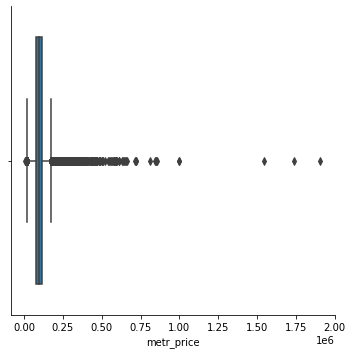

In [55]:
sns.catplot(x="metr_price", kind="box", data = n)

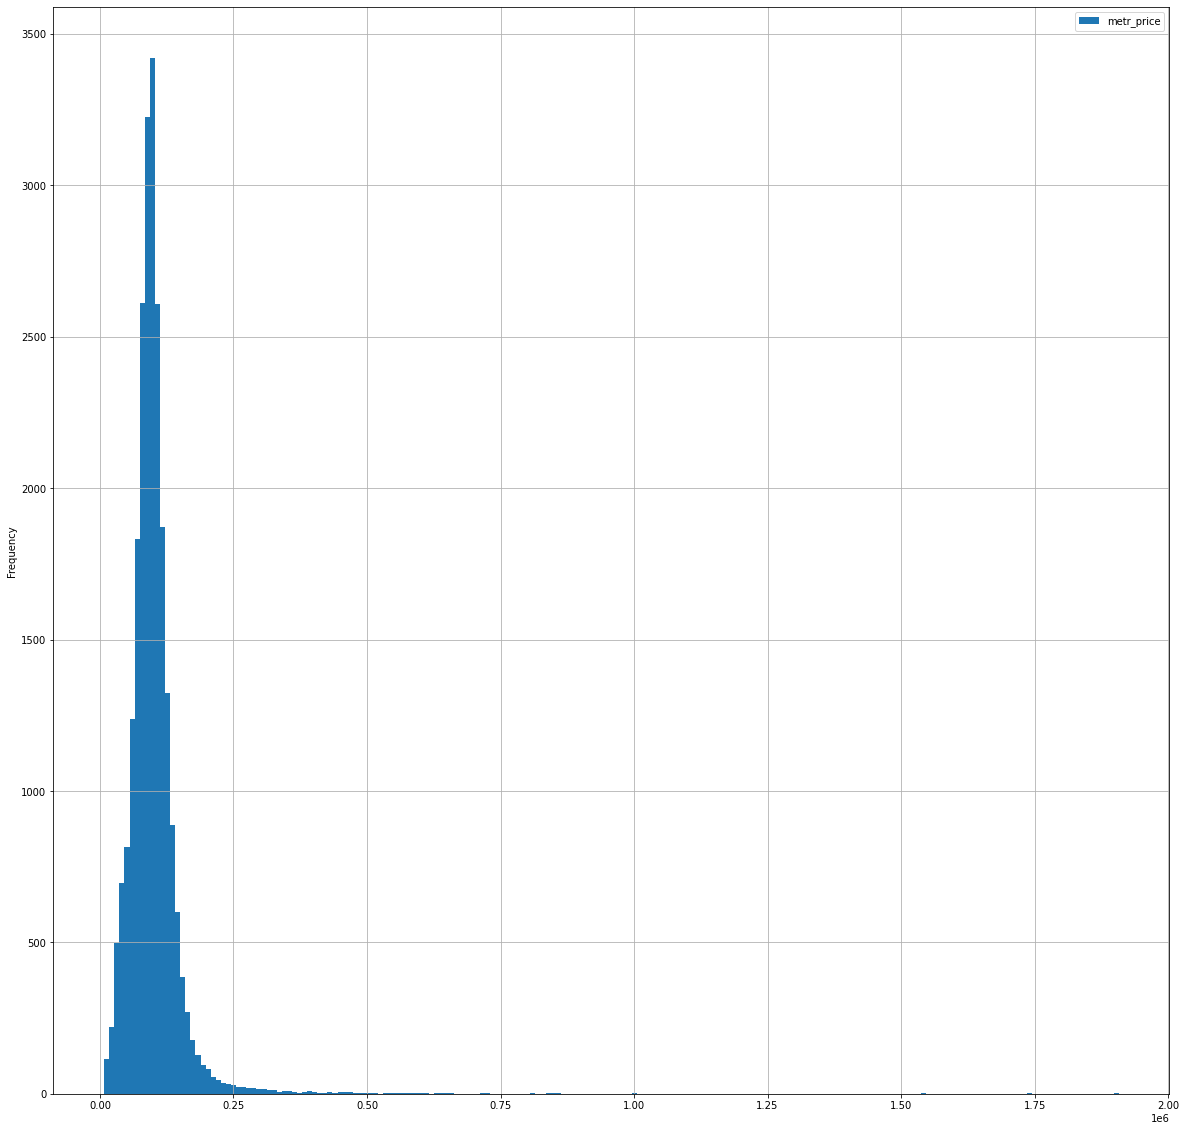

In [56]:
n.plot(kind='hist', y='metr_price', bins=200, grid=True, figsize=(20,20))
plt.show()

In [57]:
n.loc[n['metr_price']>300000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,day_of_the_week_exposition,month_exposition,year_exposition,type_floor,city_center_km
3,0,64900000.0,159.00,2015-07-24,3,2.70,9,90.345393,9,False,...,84.0,3,234.0,424.0,4.081761e+05,4,7,2015,последний,7.0
155,8,96000000.0,317.00,2017-07-07,4,3.50,8,183.000000,3,False,...,508.0,3,366.0,62.0,3.028391e+05,4,7,2017,другой,2.0
282,17,37000000.0,115.00,2018-11-15,2,2.70,17,65.000000,2,False,...,121.0,2,663.0,158.0,3.217391e+05,3,11,2018,другой,2.0
492,18,95000000.0,216.00,2017-12-05,4,3.00,18,86.000000,4,False,...,138.0,3,620.0,14.0,4.398148e+05,1,12,2017,другой,0.0
509,5,90000000.0,225.00,2016-06-26,6,2.70,5,134.000000,2,False,...,NaN,2,519.0,416.0,4.000000e+05,6,6,2016,другой,6.0
643,6,33300000.0,109.30,2018-02-16,2,3.10,6,62.105355,5,False,...,784.0,3,103.0,33.0,3.046661e+05,4,2,2018,другой,6.0
674,11,50000000.0,131.10,2019-02-11,4,3.00,11,80.800000,6,False,...,NaN,3,121.0,NaN,3.813883e+05,0,2,2019,другой,7.0
793,20,135000000.0,310.00,2018-05-22,4,3.30,20,250.000000,2,False,...,295.0,3,190.0,342.0,4.354839e+05,1,5,2018,другой,7.0
1026,20,155000000.0,310.00,2018-10-12,5,2.70,20,190.000000,3,False,...,NaN,1,603.0,NaN,5.000000e+05,4,10,2018,другой,5.0
1109,1,34878556.0,95.80,2014-12-09,2,2.70,5,58.300000,5,True,...,160.0,3,569.0,1572.0,3.640768e+05,1,12,2014,последний,0.0


Исходя из оценки описания данных и визуализации распределения, достаточно сильно выбиваются значения цены квадратного метра свыше 300 тысяч рублей. Удалим данные значения для того, чтобы исключить погрешности при работе со средними значениями далее

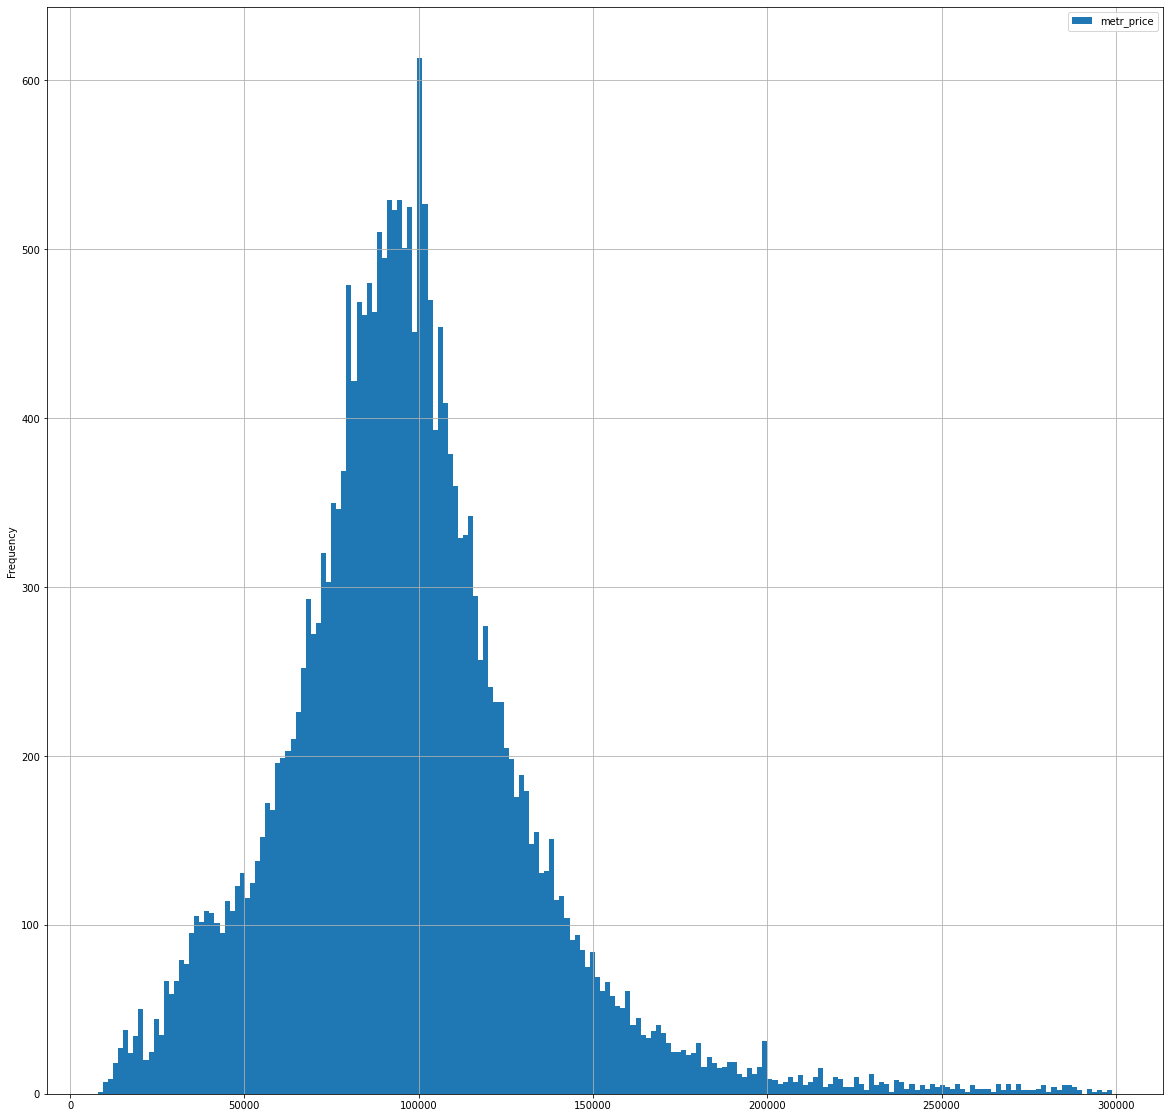

In [58]:
n['metr_price'] = n.loc[n['metr_price']<300000, 'metr_price']
n.plot(kind='hist', y='metr_price', bins=200, grid=True, figsize=(20,20))
plt.show()

После удаления части значений распределение стало более равномерным.

В результате работ этапа в наборе данных появились дополнительные параметры, благодаря чему в дальнейшем будет возможно оценить взаимосвязь максимального числа параметров между собой (например, связь характеристик даты размещения с ценой жилья).

### Проведите исследовательский анализ данных

Изучим ряд параметров объектов при помощи гистограмм:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

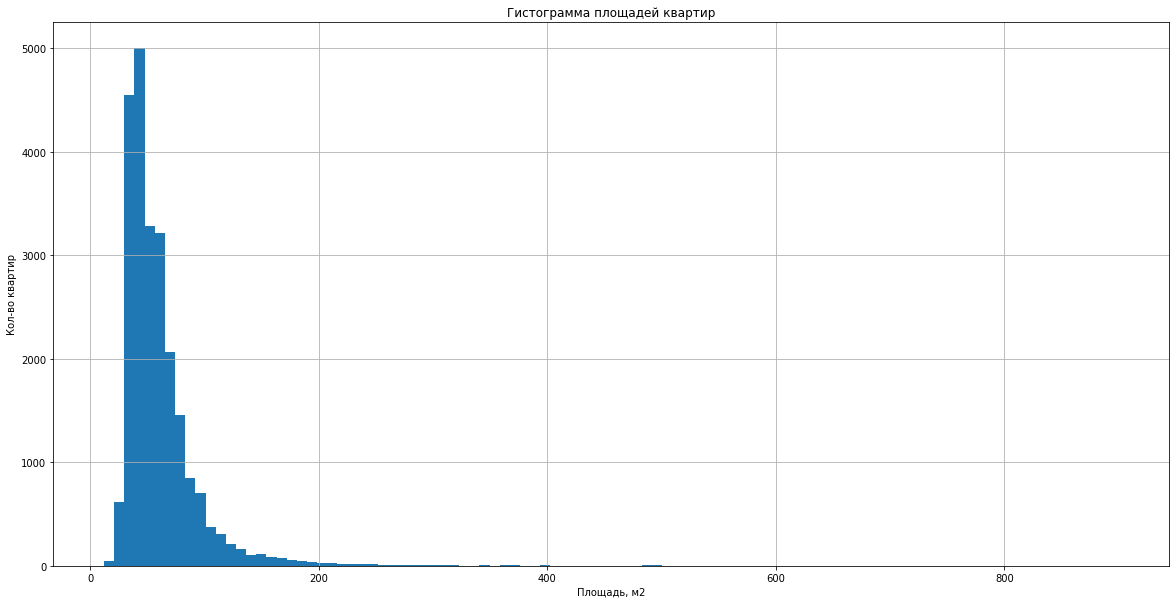

In [59]:
#гистограмма для оценки распределения площадей
ax = n['total_area'].hist(bins=100,  figsize=(20,10))\
    .set(title = 'Гистограмма площадей квартир', xlabel = 'Площадь, м2', ylabel = 'Кол-во квартир')

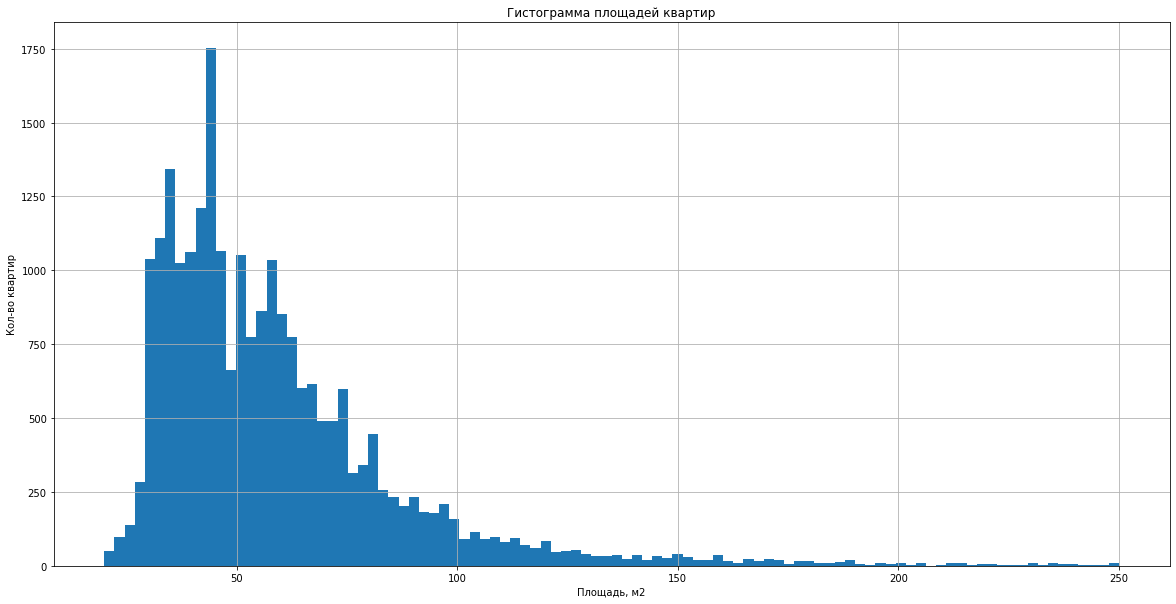

In [53]:
#гистограмма для более детальной оценки распределения площадей
ax = n['total_area'].hist(bins=100, range = (20, 250), figsize=(20,10))\
    .set(title = 'Гистограмма площадей квартир', xlabel = 'Площадь, м2', ylabel = 'Кол-во квартир')

В целом, график соответствует распределению Пуассона, но есть ряд квартир с площадью выше среднего. Удалять их из рассмотрения не стоит, так как главная задача исследования - оценка стоимости объектов недвижимости и данные об объектах с большой площадью могут быть полезны.
Чаще всего объекты имеют площадь до 100 квадратных метров. Наиболее часто встречаются объявления о квартирах площадью 40 м2. 

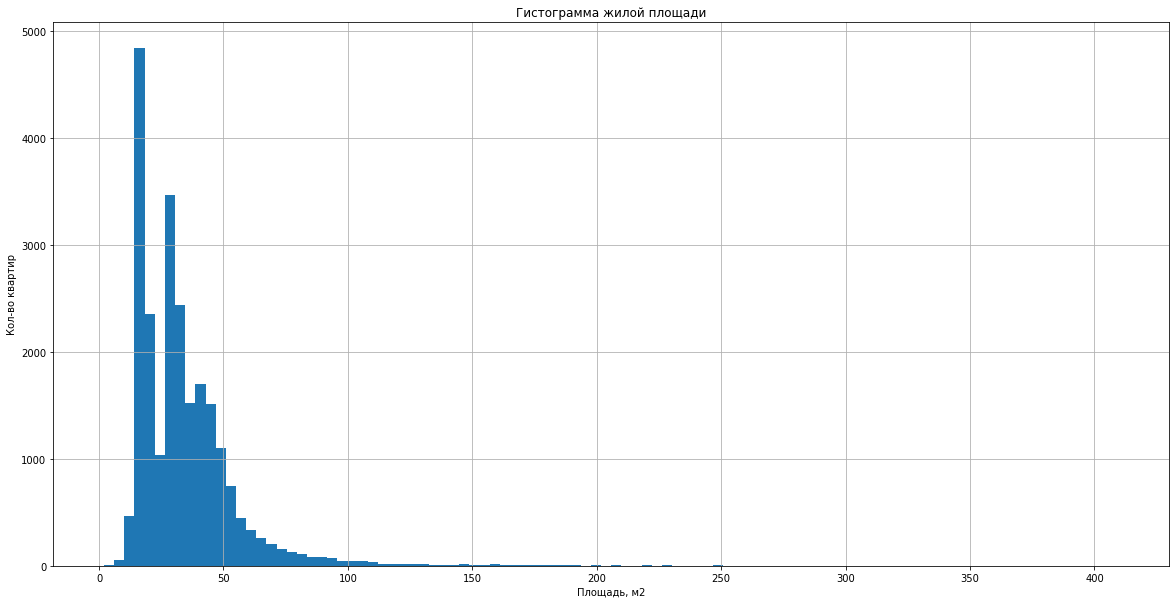

In [60]:
#гистограма оценки жилой площади
ax = n['living_area'].hist(bins=100,  figsize=(20,10))\
    .set(title = 'Гистограмма жилой площади', xlabel = 'Площадь, м2', ylabel = 'Кол-во квартир')

Была получена гистограмма с двумя пиками, что свидетельствует о смешивании нескольких разных выборок. Взможно, это связано с тем, что одновременно рассматриваются и студии с малой площадью, и полноценные квартиры с несколькими комнатами.
Для улучшения качества анализа в дальнейшем рекомендуется разделить студии и квартиры на несколько датасетов и произвести отдельные исследования.

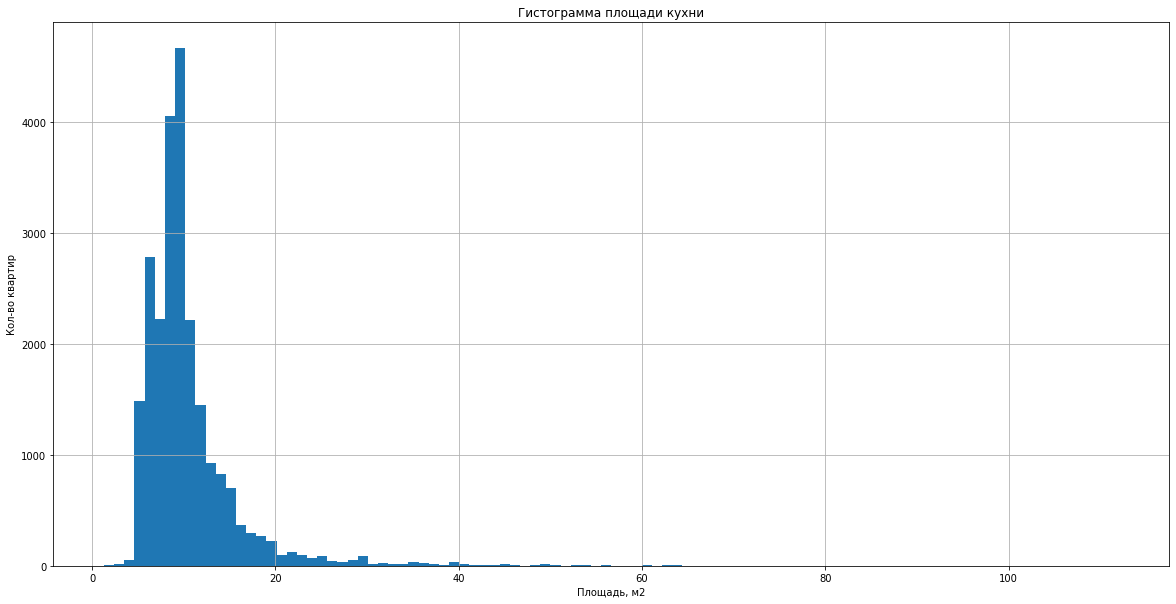

In [61]:
#гистограмма для оценки распределения площади кухни
ax = n['kitchen_area'].hist(bins=100,  figsize=(20,10))\
    .set(title = 'Гистограмма площади кухни', xlabel = 'Площадь, м2', ylabel = 'Кол-во квартир')

Распределение площадей кухни близко к распределению Пуассона, четко выраженный пик располагается в районе 10-12 квадратных метров, что соответствует и характеристикам типовых квартир. Есть и большие кухни, которые, как было выявлено ранее, располагаются в квартирах с большой площадью и возможно включают в себя столовую, бар и иные локации по предпочтениям хозяев.

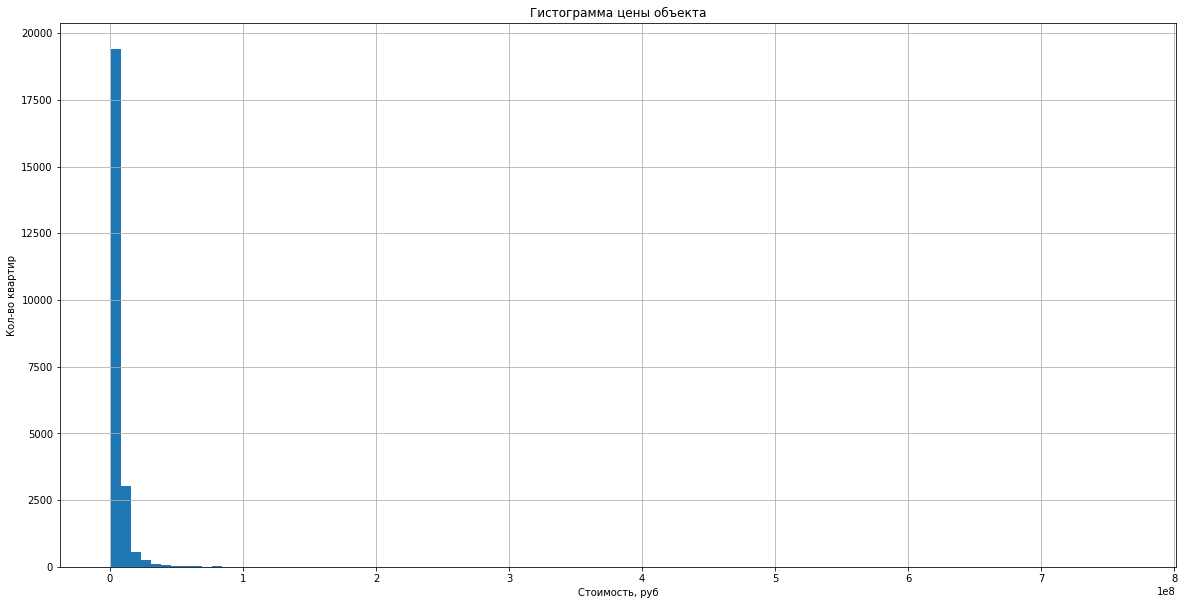

In [62]:
#гистограмма для оценки распределения цены объекта
ax = n['last_price'].hist(bins=100,  figsize=(20,10))\
    .set(title = 'Гистограмма цены объекта', xlabel = 'Стоимость, руб', ylabel = 'Кол-во квартир')

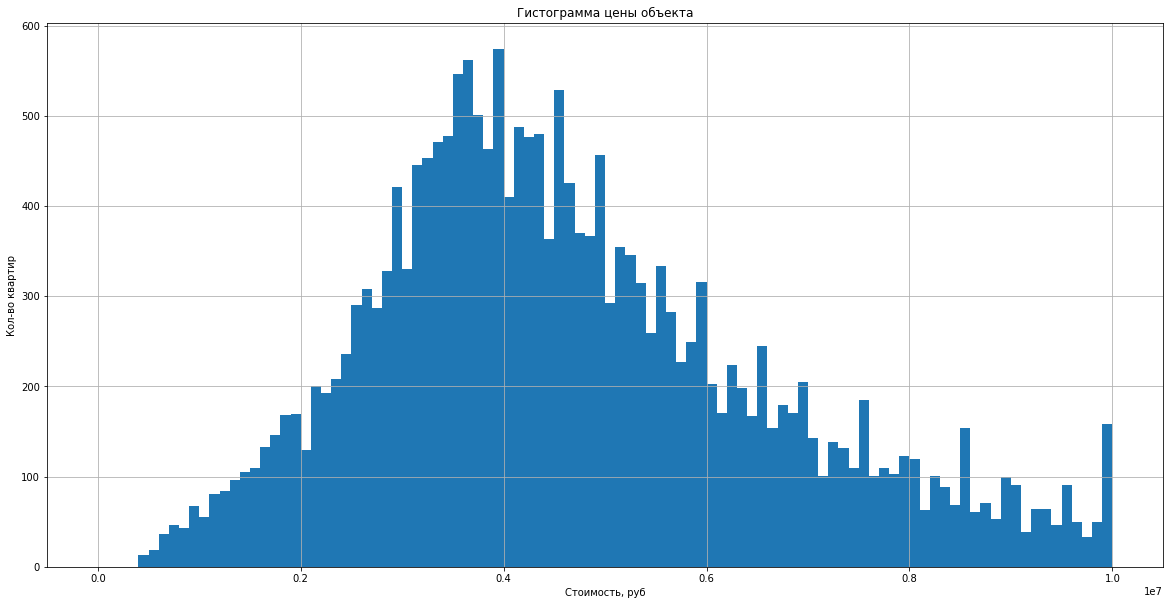

In [51]:
#гистограмма для оценки распределения цены объекта детальный срез
ax = n['last_price'].hist(bins=100,  range=(0, 10000000), figsize=(20,10))\
    .set(title = 'Гистограмма цены объекта', xlabel = 'Стоимость, руб', ylabel = 'Кол-во квартир')

Основной пик цен приходится на 3-4 миллиона рублей, многожество предложений было до 5 миллионнов рублей, для данных, собранных с 2014 по 2019 год, очень реалистично. В основном, объекты недвижимости продавались до 10 миллионов рублей. Отдельные большие значения стоимости соответствуют объектам с большой площадью

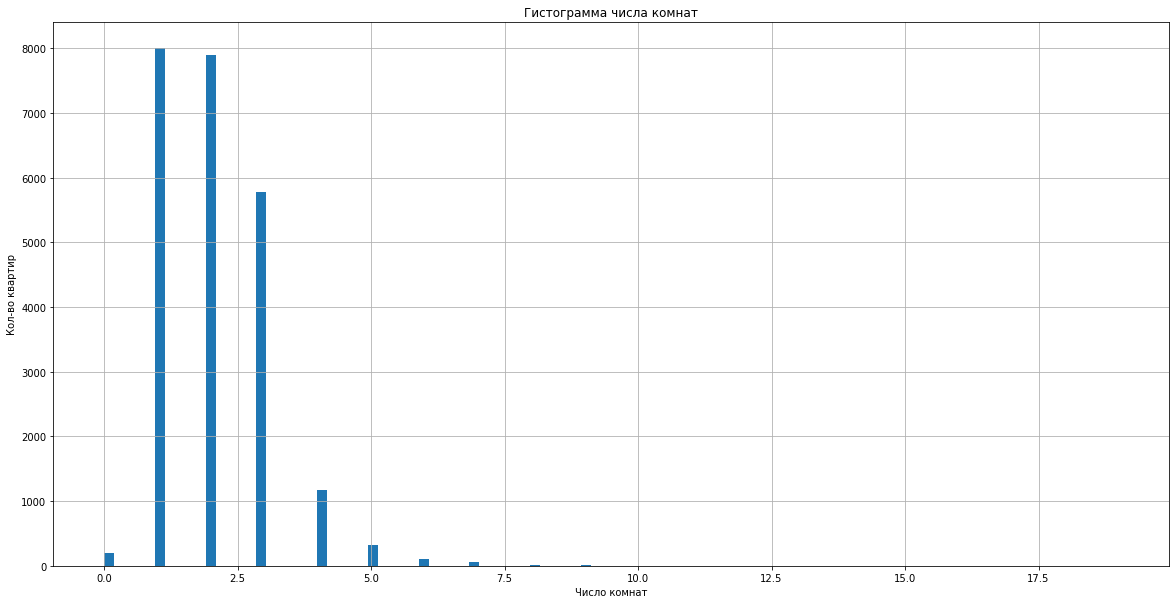

In [63]:
#гистограмма для оценки распределения количества комнат
ax = n['rooms'].hist(bins=100,  figsize=(20,10))\
    .set(title = 'Гистограмма числа комнат', xlabel = 'Число комнат', ylabel = 'Кол-во квартир')

Чаще всего продавались одно- и двухкомнатные квартиры. Студий в общей массе оказалось не столь много, но возможно авторы объявлений о продаже студий приимали число комнат в них за одну.

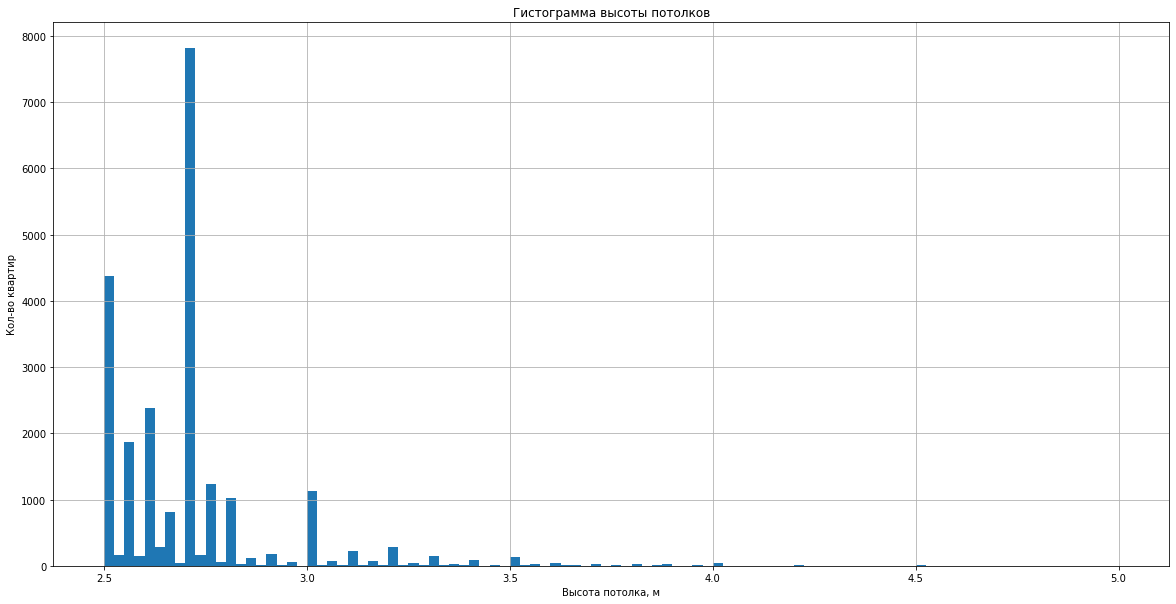

In [64]:
#гистограмма для оценки распределения высоты потолков
ax = n['ceiling_height'].hist(bins=100,  figsize=(20,10))\
    .set(title = 'Гистограмма высоты потолков', xlabel = 'Высота потолка, м', ylabel = 'Кол-во квартир')

Высота потолков распределена нестандартно, есть четкий пик в районе 2,7 метров, а также провал на уровне 2,65 метров. Причиной распределения может являться разнообразие рынка жилья - дома более старой постройки имеют более высокие потолки, дома в сельской местности также часто ниже домов в городе, так как в поселках возможно частное строительство, которое нормами не регламентируется и каждый строит как хочет.

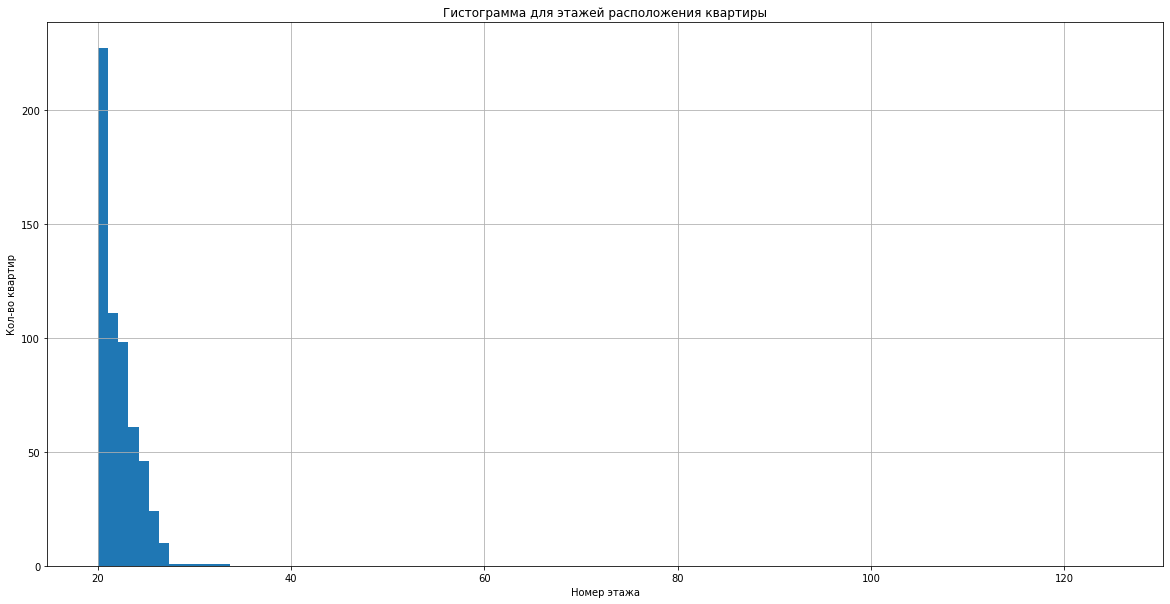

In [65]:
#гистограмма для оценки распределения этажа квартиры
ax = n['floor'].hist(bins=100, range=(20, 125), figsize=(20,10))\
    .set(title = 'Гистограмма для этажей расположения квартиры', xlabel = 'Номер этажа', ylabel = 'Кол-во квартир')

Распределение квартир по этажам напоминает распределение Пуассона. Пик приходится на 1-2 этаж, большая часть предложений - это объекты, располагающиеся до 5 этажа. Менее часто продают квартиры, располагающиеся с 6 по 9 этаж.
Для определения причин частого появления квартир, располагающихся ниже 6 этажа, стоит рассмотреть гистограмму распределения высоты домов, возможно, большая часть объектов располагалась в пятиэтажках и ниже.

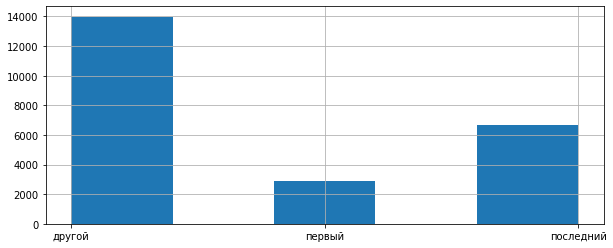

In [66]:
#гистограмма для оценки распределения типа этажа квартиры
n['type_floor'].hist(bins=5, grid=True, figsize=(10,4))
plt.show()

Чаще всего квартиры  располагаются не на первом, и не на последних этажах.

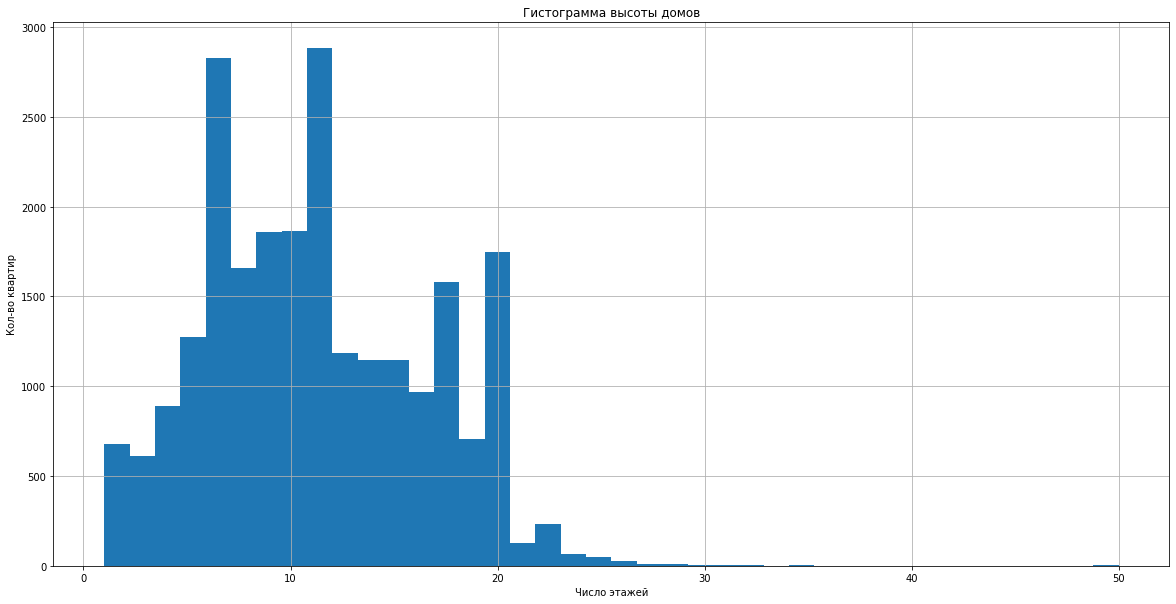

In [67]:
#гистограмма для оценки распределения высоты домов
ax = n['floors_total'].hist(bins=40, figsize=(20,10))\
    .set(title = 'Гистограмма высоты домов', xlabel = 'Число этажей', ylabel = 'Кол-во квартир')

Высокая частота предложений квартир с 2 по 5 этажи вполне объяснима тем, что большая часть домов в выборке эти этажи в своем составе имеют. Больше всего домов высотой 7-9 этажей, также выделяются пики среди 20-этажек и 12-этажек.
Есть также и дома с 1-2 этажами, скорее всего, это объекы частного сектора или старой застройки

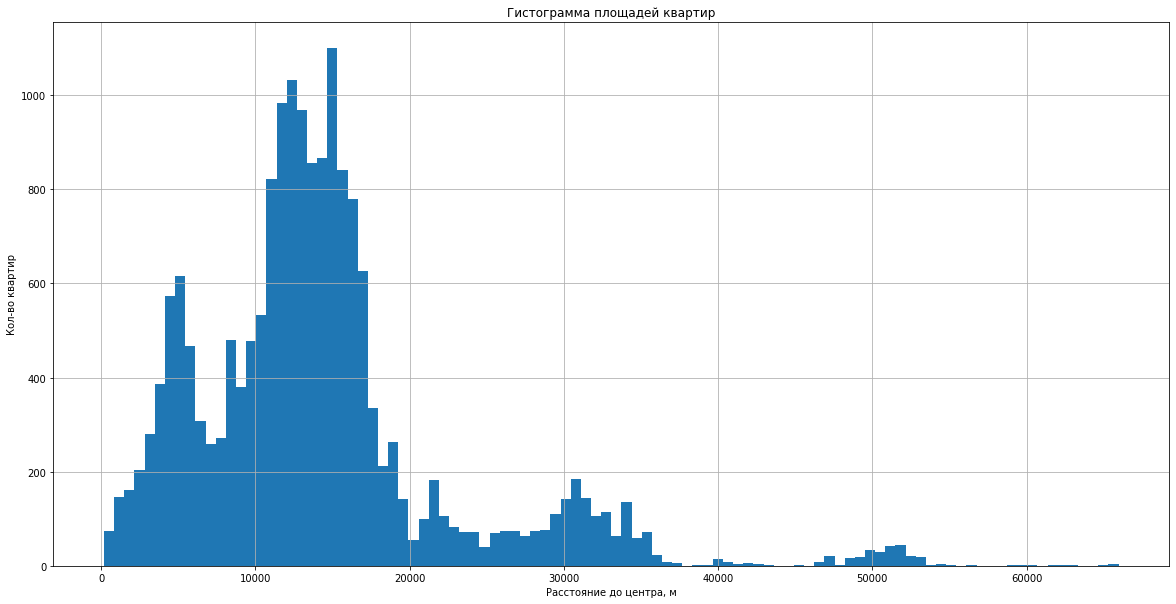

In [54]:
#гистограмма для оценки распределения расстояния от объекта до центра города
ax = n['cityCenters_nearest'].hist(bins=100, figsize=(20,10))\
    .set(title = 'Гистограмма площадей квартир', xlabel = 'Расстояние до центра, м', ylabel = 'Кол-во квартир')

У распределения можно выделить несколько пиков, и связано это с тем, что в наборе данных присутстсвуют одновременно сведения об объектах в населенных пунктах около Санкт-Петербурга, которые невелики по площади, и объекты в Санкт-Петербурге, где расстояние от центра города до окраин может быть значительным.
Чаще всего объект недвижимости располагается в пределах 15-17 км от центра, достаточно много объектов находятся в пределах 10 км от центра.
Для более точного анализа и исседования в дальнейшем рекомендуется разделить выборку на несколько частей - объекты в Санкт-Петербурге и объекты в иных населенных пунктах около Санкт-Петербурга

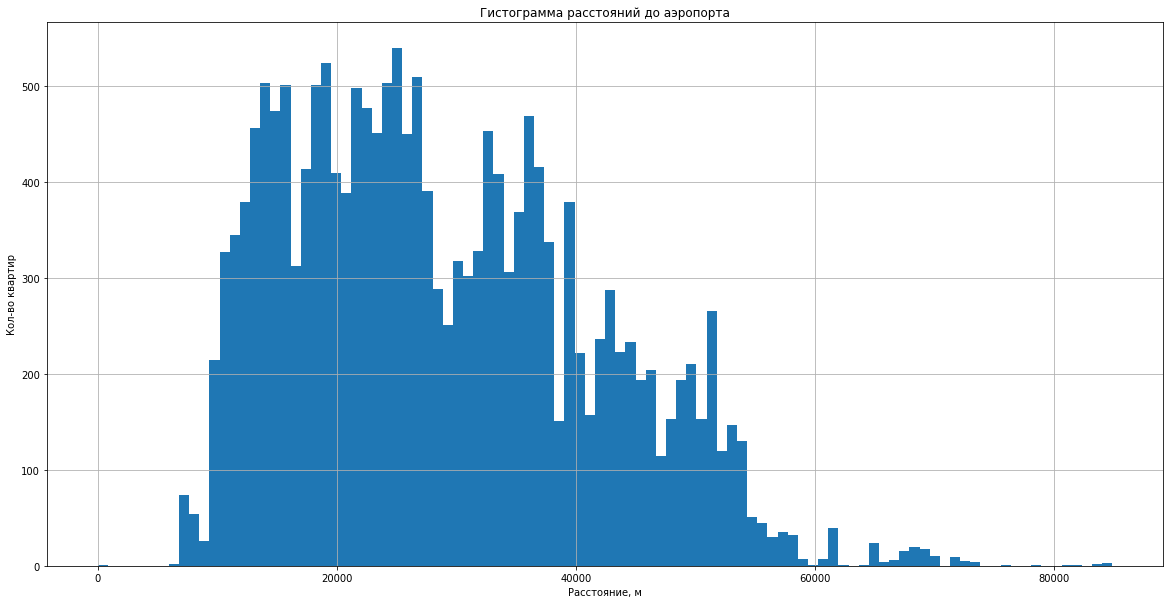

In [69]:
#гистограмма для оценки распределения расстояния до ближайшего аэропорта
ax = n['airports_nearest'].hist(bins=100, figsize=(20,10))\
    .set(title = 'Гистограмма расстояний до аэропорта', xlabel = 'Расстояние, м', ylabel = 'Кол-во квартир')

Распределение значений расстояний до аэропорта также демонстрирует, что в выборке фигурируют объекты двух типов - для городов рядом с Санкт-Петербургом ближайший аэропорт остается тем же, что и для объектов в Санкт-Петербурге, однако из города доехать до аэропорта ближе.
Чаще всего аэропорт от объекта располагается на расстоянии 20-40 км

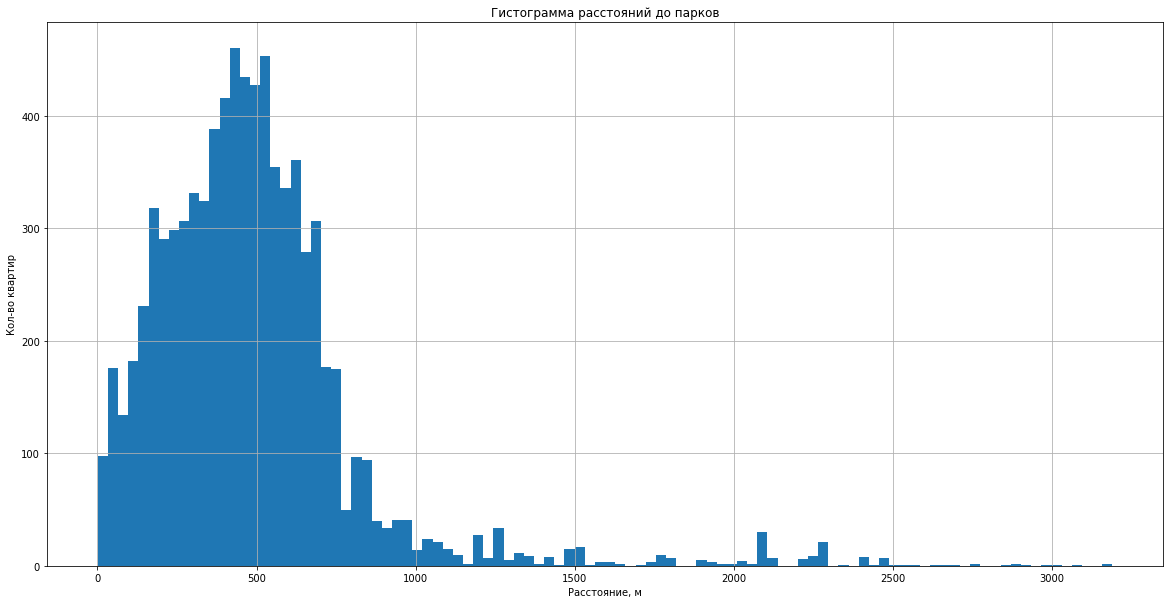

In [70]:
#гистограмма для оценки распределения расстояния до ближайшего парка
ax = n['parks_nearest'].hist(bins=100, figsize=(20,10))\
    .set(title = 'Гистограмма расстояний до парков', xlabel = 'Расстояние, м', ylabel = 'Кол-во квартир')


Распределение расстояний до парков практически соответствует распределению Пуассона. Стоит отметить, что чаще всего до парка менее километра, положительный показатель развитости городской инфраструктуры.

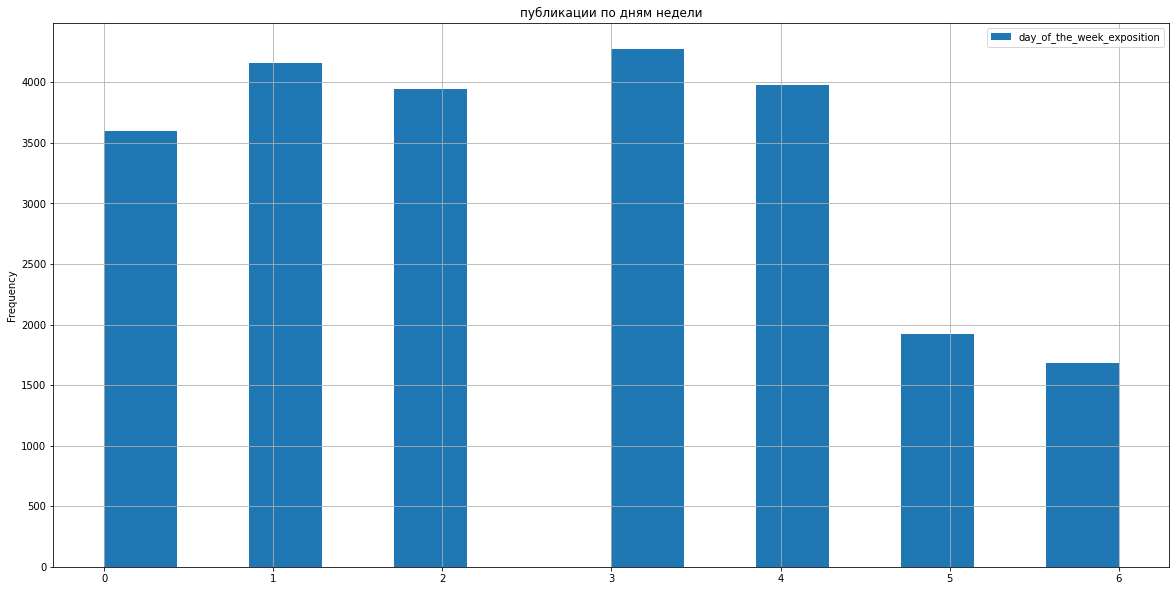

In [71]:
#гистограмма для оценки распределения частоты публикаций по дням
n.plot(kind='hist', title='публикации по дням недели', y='day_of_the_week_exposition', bins=14, grid=True, figsize=(20,10))
plt.show()

Наибольшее чсило публикаций приходится на рабочие дни, особенно стоит выделить вторник и четверг, в которые публикуется максимальное число предложений. В выходные ддни шанс увидеть новое объявление о квартире минимален

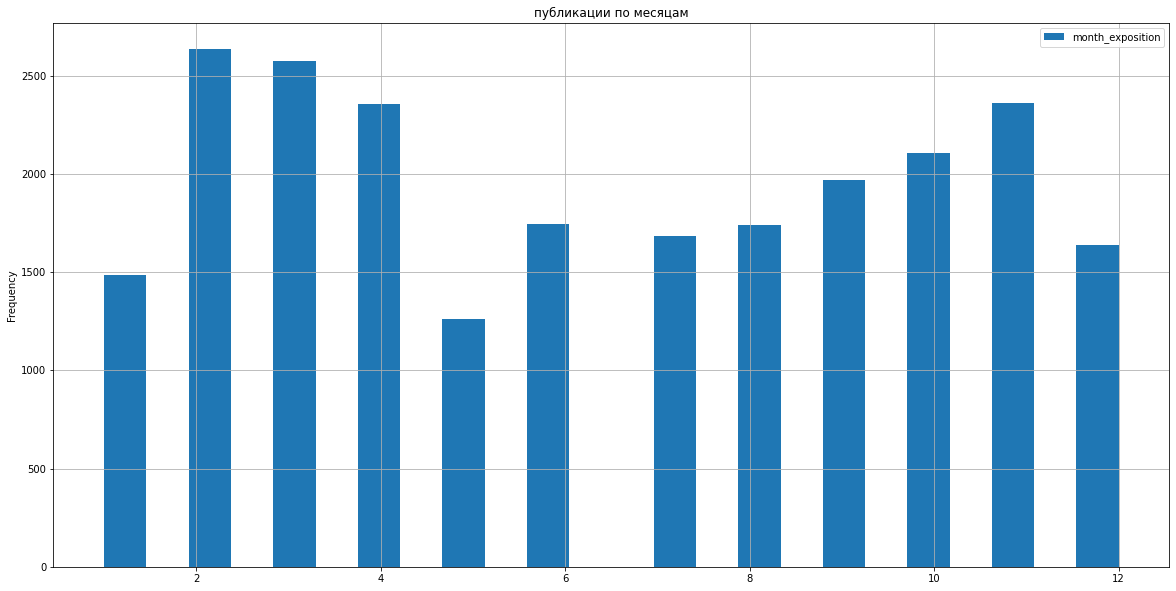

In [72]:
#гистограмма для оценки распределения частоты публикаций по месяцам
n.plot(kind='hist', title='публикации по месяцам', y='month_exposition', bins=24, grid=True, figsize=(20,10))
plt.show()

Отмечается определенная сезонность. Меньше всего публикаций приходится на январь и май, в периоды с минимальным числом рабочих дней из всех месяцев в году. В целом, это коррелирует с результатами оценки распределения частоты публикаций по дням недели - на выходных авторы объявлений не заинтересованы в их оформлении, ведь праздники всегда снижают покупательскую способность, так как являются источниками дополнительных расходов, эмоционально захватывают потенциальных покупателей, также нет возможности оформить ипотеку, что также отрицательно влияет на процесс продажи.
Стоит отметить, что максимально часто новые объявления появляются в феврале, марте и апреле. Данную тенденцию можно связать с общим оживлением рынка в данный период, сезоном премий во многих компаниях, которые являются стимулом покупателей для совершения сделки, из-за чего объявления не будут висеть долгое время.
Второй пик приходится на осенний сезон, в который после летних отпусков начинает расти активность рынка. Также ряд участников рынка в осенний период меняют место жительства (смена работы после отпуска, начало учебы в другом городе), поэтому операции с недвижимостью вновь становятся популярными.

Оценим длительность продаж для квартир исходя из данных столбца о сроках размещения объявления

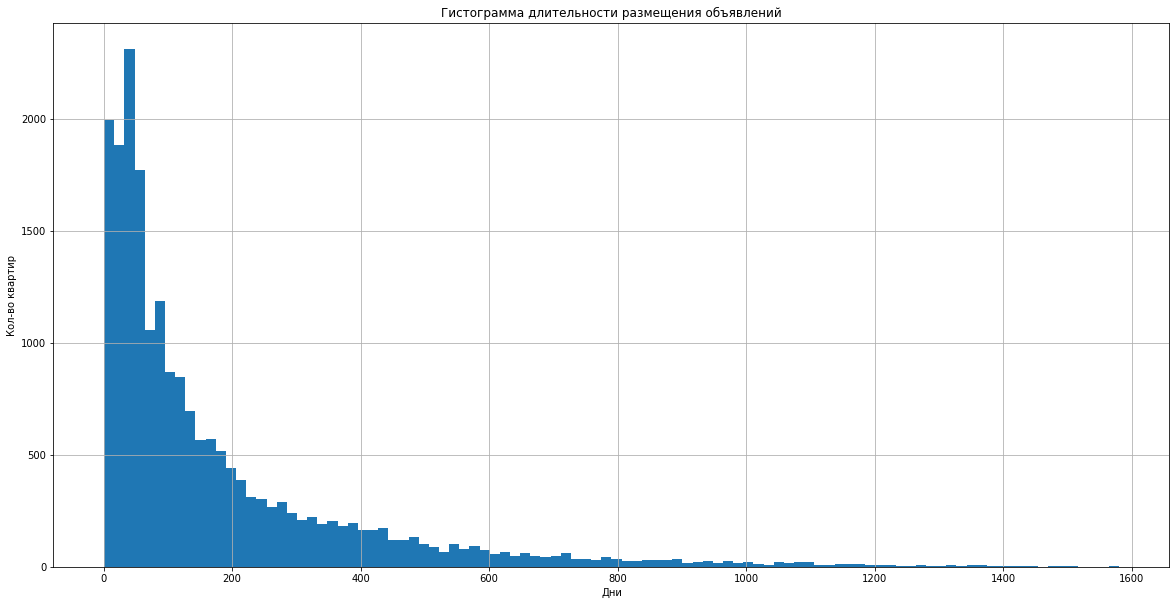

In [73]:
ax = n['days_exposition'].hist(bins=100, figsize=(20,10))\
    .set(title = 'Гистограмма длительности размещения объявлений', xlabel = 'Дни', ylabel = 'Кол-во квартир')


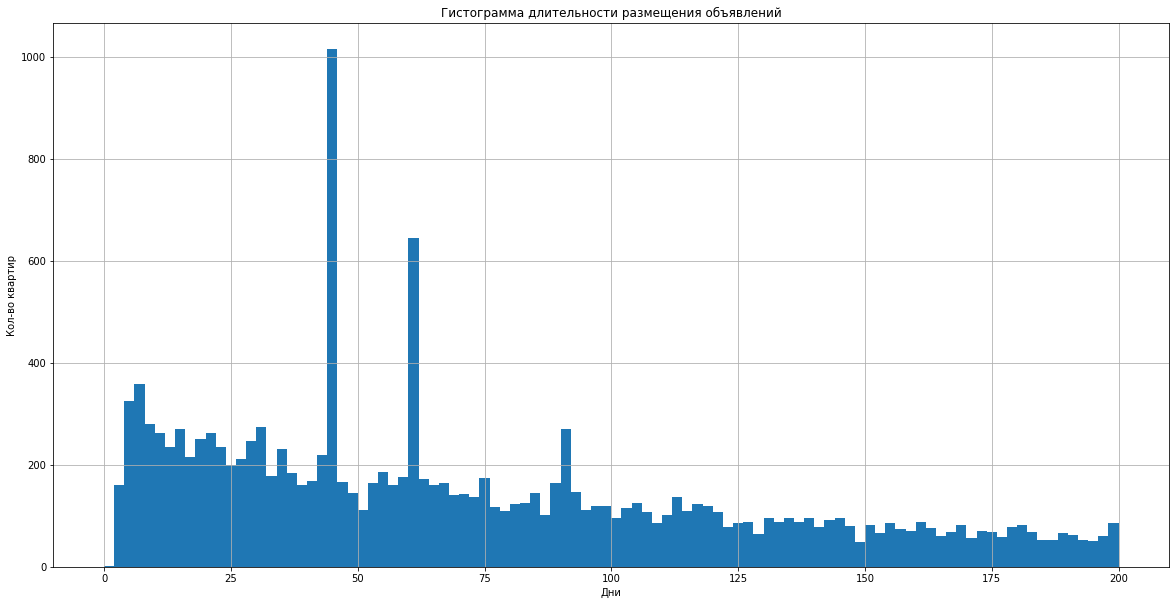

In [56]:
#более детальная оценка сроков размещения
ax = n['days_exposition'].hist(bins=100, figsize=(20,10), range = (0, 200))\
    .set(title = 'Гистограмма длительности размещения объявлений', xlabel = 'Дни', ylabel = 'Кол-во квартир')

In [74]:
n['days_exposition'].describe()

count    20391.000000
mean       180.754156
std        219.745522
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [75]:
n['days_exposition'].median()

95.0

Распределение сроков продажи квартир соответствует распределению Пуассона. Средняя длительность размещения составляла 180 дней, минимально объект недвижимости продавался за 1 день. При этом, чаще всего квартиры продавались за 95 дней. Возможно, такое смещение среднего было вызвано наличием в выборке данных об элитных объектах, продать которые значительно сложнее, ведь целева аудитория невелика.
Быстрыми продажами возможно считать продажи в период до 45 дня с момента размещения объявления. Необычно долгие продажи - это сделки, в которых объявление находилось на сайте более 231 дня. 
Стоит отметить, что есть два пика - 45 дней и 60 дней. Скорее всего,это связано с тем, что изначально продавец завышает цену и через 1,5-2 месяца снижает ее, так как не может найти покупателей, после чего условия продажи устраивают приобретателей. Также на оформление ипотеки необходимо время, из-за чего сделка может растянуться по времени, поэтому объявления размещаются до 2 месяцев.

Оценим влияние различных факторов на стоимость квартиры, таких как общая площадь, жилая площадь и площадь кухни, числа комнат, расположения квартиры в доме и даты размещения объявления. Используем диаграммы рассеивания и тепловой карты

In [74]:
cor = n.corr()

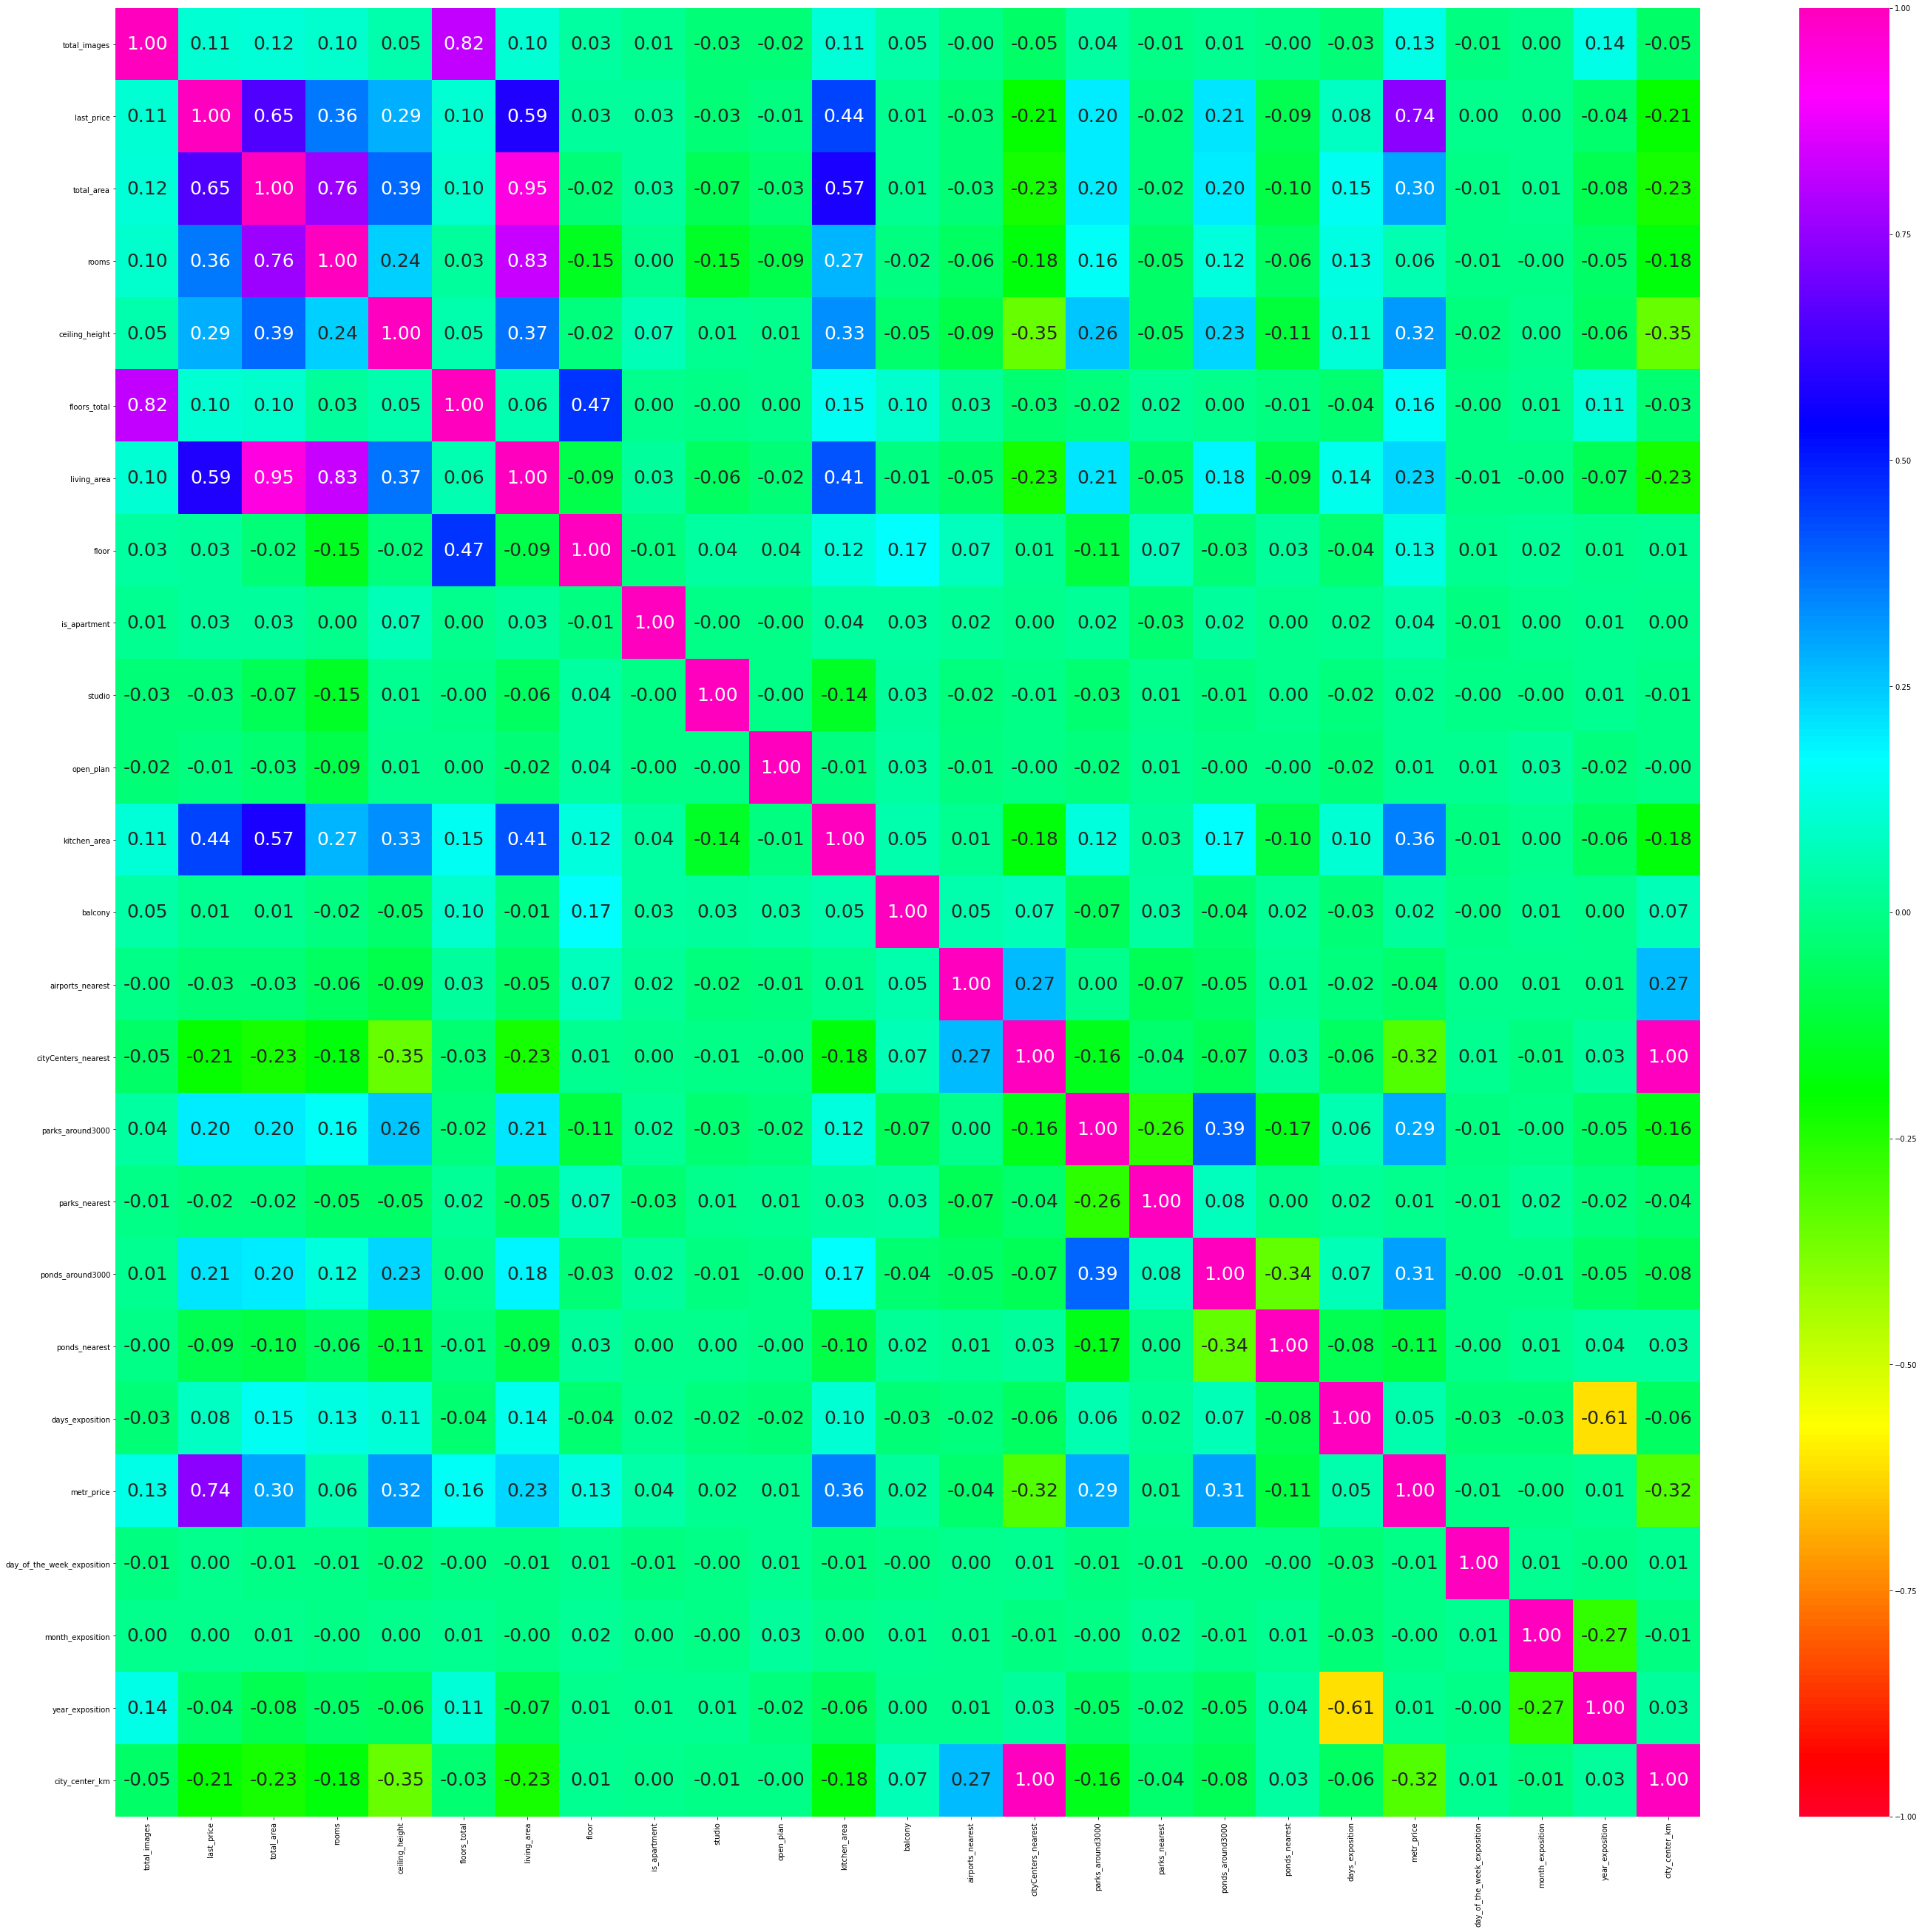

In [75]:
#вывод тепловой карты
plt.figure(figsize=(48,45))
sns.heatmap(data=cor, 
            annot=True,
            fmt=".2f", 
            vmin=-1, 
            vmax=1, 
            cmap="gist_rainbow",
            annot_kws={'size': 25})

plt.show()

Максимальное влияние на цену оказывают общая площадь квартиры, площадь жилой и кухонной зон, число комнат. Стоит отметить, что при определении стоимости минимально учитывается наличие рядом парков и прудов. Незначительно снижает цену удаленность аэропорта.

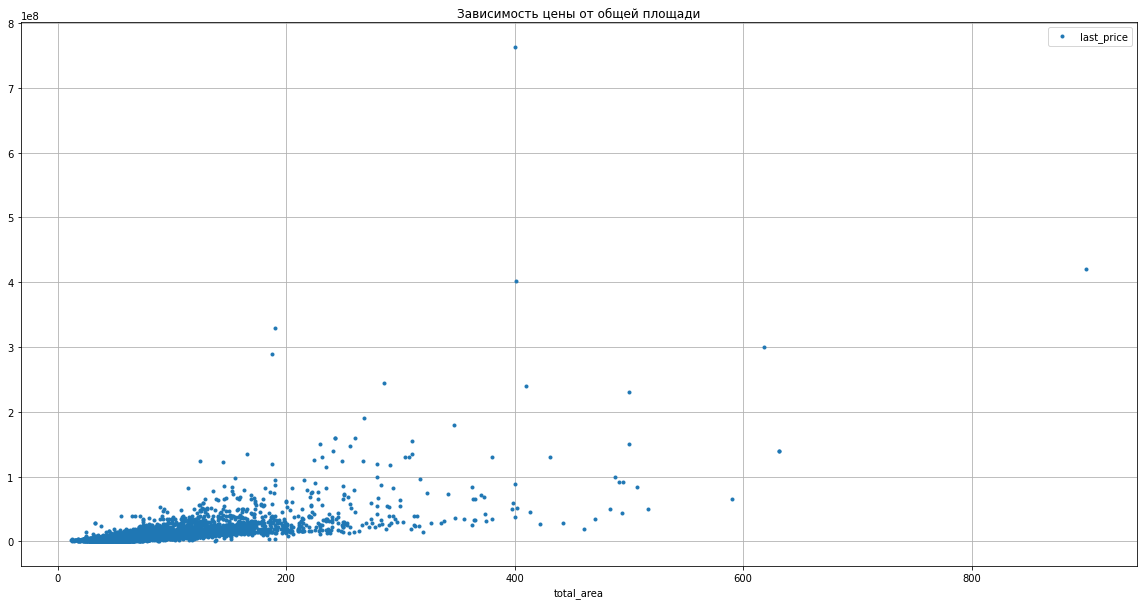

In [76]:
#оценка зависимости цены от общей площади
n.plot(x='total_area', y='last_price',
                  style='.', title='Зависимость цены от общей площади',
                   grid=True, sharex=False, figsize=(20,10))
plt.show()

Видна прямая корреляция между ценой и общей площадью объекта. Очень логично, ведь стоимость квартиры оценивается исходя из стоимости квадратного метра, и чем квадратных метров больше, тем и цена выше

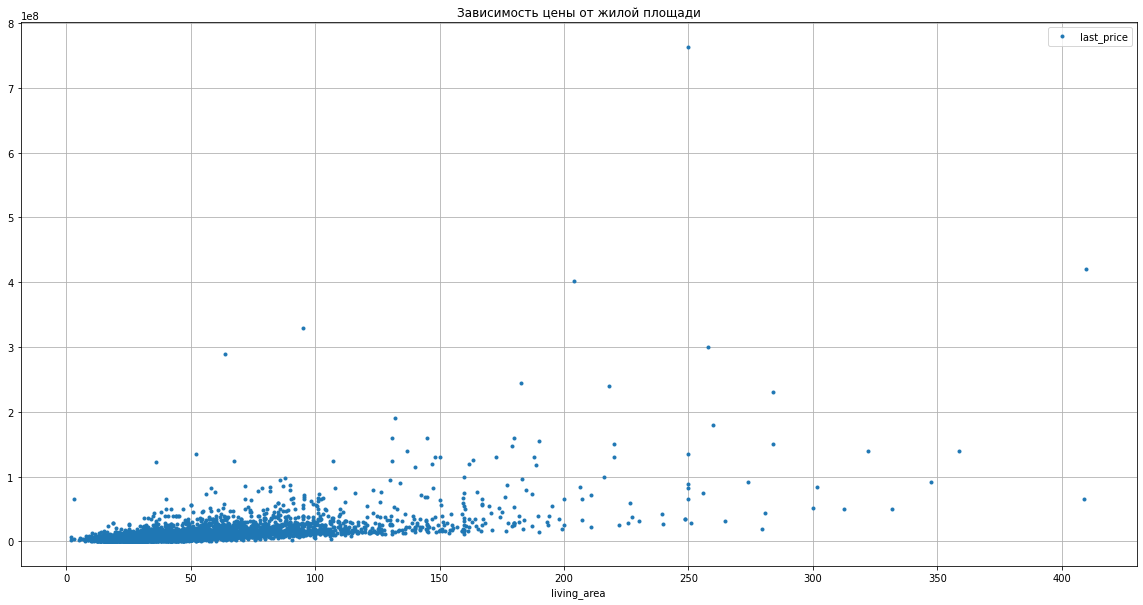

In [77]:
#оценка зависимости цены от жилой площади
n.plot(x='living_area', y='last_price',
                  style='.', title='Зависимость цены от жилой площади',
                   grid=True, sharex=False, figsize=(20,10))
plt.show()

Влияние общей жилой площади на стоимость уже менее значимо, что подтверждается как диаграммой, так и тепловой картой - коэффициент корреляции стоимости и размеров жилой площади 0,59, когда коэффициент корреляции стоимости с размером общей площади 0,68

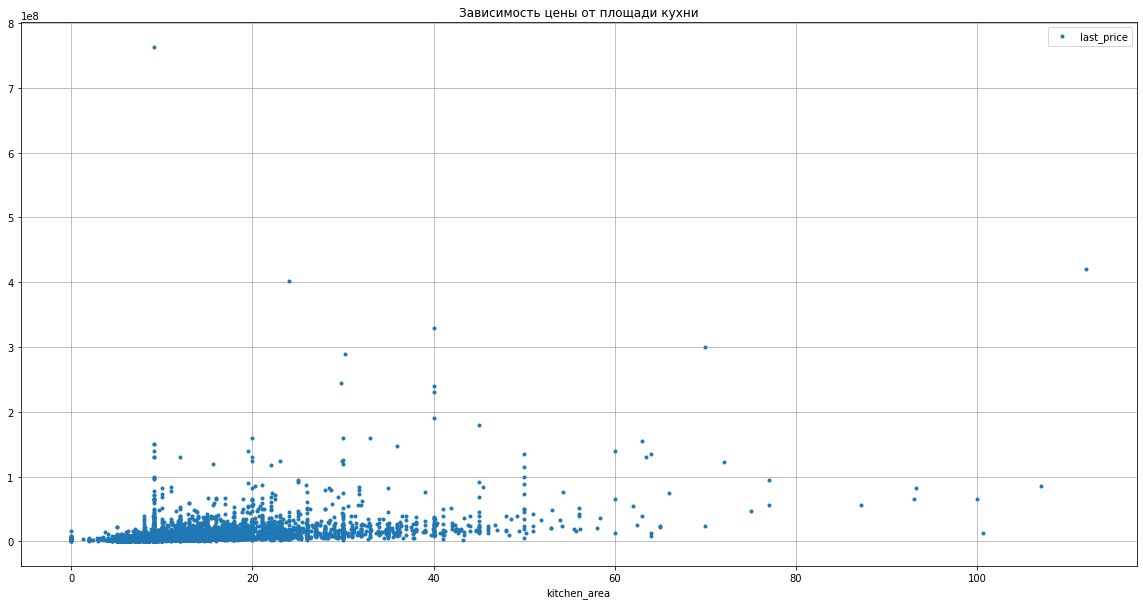

In [78]:
#оценка зависимости цены от площади кухни
n.plot(x='kitchen_area', y='last_price',
                  style='.', title='Зависимость цены от площади кухни',
                   grid=True, sharex=False, figsize=(20,10))
plt.show()

Тут слабая прямая зависимость, коэффициент корреляции стоимости с размером кухни - 0,44

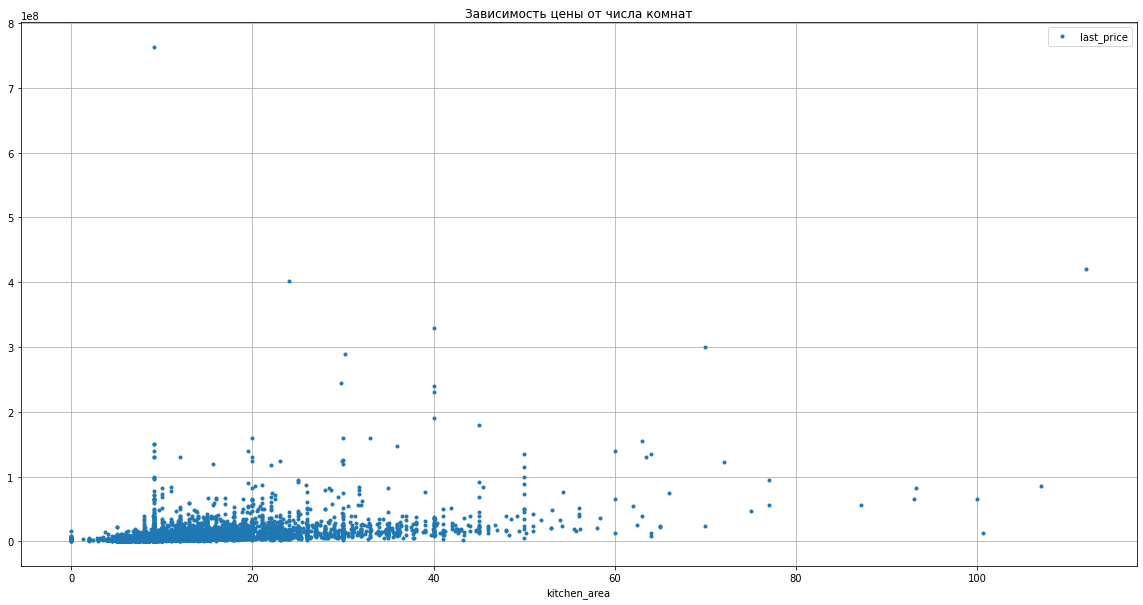

In [79]:
#оценка зависимости цены от числа комнат
n.plot(x='kitchen_area', y='last_price',
                  style='.', title='Зависимость цены от числа комнат',
                   grid=True, sharex=False, figsize=(20,10))
plt.show()

Число комнат прямо влияет на цену, но не очень значительно. Коэффициент корреляции - 0,36

Для того, чтобы оценить зависимость цены от типа этажа, оценим медианное значение цены для каждого из видов этажей, так как число объектов в категориях различно и строить график будет некорректно. При этом, медиана покажет нам часто встречающуюся стоимость, что позволит оценить итоговую стоимость объекта

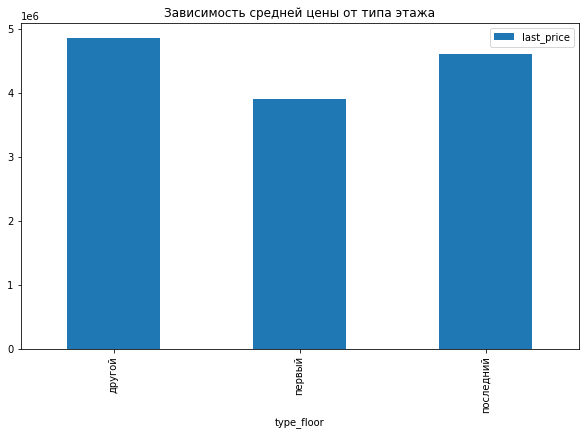

In [80]:
n.pivot_table(index='type_floor', values='last_price', aggfunc=('median')).plot(style='-',title='Зависимость средней цены от типа этажа', figsize=(10,6), kind='bar')
plt.show()

В ходе оценки медианных значений стоимости было отмечено, что квартиры на первых этажах дешевле всего, максимальная стоимость для квартир не на первом и не на последнем этаже.
Это объясняется тем, что квартиры на первых этажах менее безопасны от воров, квартиры на последнем этаже находятся прямо под крышей и при наличии проблем с качеством крыш, выелик риск потопа. 

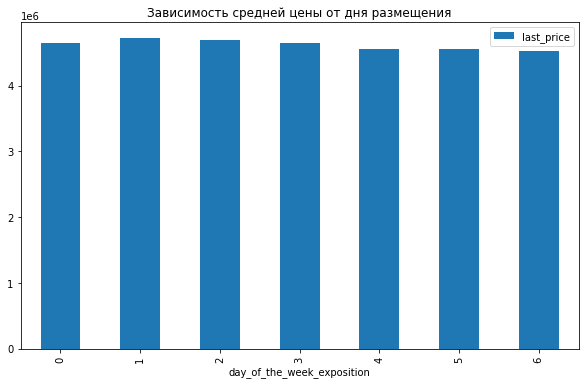

In [81]:
#оценка зависимости цены от дня размещения путем использования сводной таблицы
(
    n.pivot_table(index='day_of_the_week_exposition', values='last_price', aggfunc=('median'))
    .plot(title='Зависимость средней цены от дня размещения', figsize=(10,6), kind='bar')
)
plt.show()

Цена никак не зависит от дня размещения объявления, черных пятниц на Яндекс.Недвижимости нет 

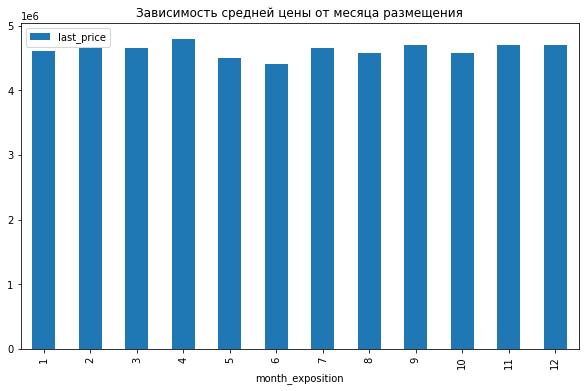

In [82]:
#оценка зависимости цены от месяца размещения путем использования сводной таблицы
(
    n.pivot_table(index='month_exposition', values='last_price', aggfunc=('median'))
    .plot(title='Зависимость средней цены от месяца размещения', figsize=(10,6), kind='bar')
)
plt.show()

Максимально дорого продаются квартиры в феврале, апреле и сентябре. Дешевле всего летом. Тренд связан со спадом деловой активности в июне и его ростом в феврале-апреле, а также повышением спроса на недвижимость в сентябре.
Интересный пик в июле.

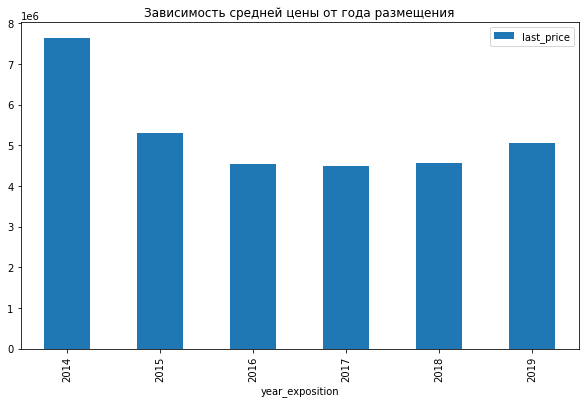

In [83]:
#оценка зависимости цены от года размещения путем использования сводной таблицы
(n.pivot_table(index='year_exposition', values='last_price', aggfunc=('median'))
 .plot(title='Зависимость средней цены от года размещения', figsize=(10,6), kind='bar')
)
plt.show()

Квартиры дешевели до 2017 года, а после вновь начали расти. Однако, если оценивать коэффициент корреляции, то зависимость итоговой цены от года размещения минимальна. Возможно, с годами большее число владельцев недорогих объектов недвижимости(например, аппартаментов и студий) начали регестрироваться на сервисе и в целом продавать подобные объекты. Стоит отметить, что для многих россиян 2014 год был связан с падением доходов и спрос на дорогостоящие объекты в дальнейшем также упал.

Однако, аналитика по общей стоимости объекта не может дать полной информации о рынке, ведь каждая из квартир отличается друг от друга по площади. 
Оценим, как меняется цена квадратного метра в зависимости от города. Выделим 10 населенных пунктов, где число объявлений максимально, определим для каждого из населенных пунктов максимальную, минимальную и среднюю стоимость объекта недвижимости.
Для реализации операций используем метод сводных таблиц

(
    n.pivot_table(index='locality_name', values='last_price', aggfunc=['count', 'mean', 'median'])\
.sort_values(('count', 'last_price'), ascending=False)\
.head(10)\
.sort_values(('mean', 'last_price'), ascending=False)

In [84]:
(
    n.pivot_table(index='locality_name', values='metr_price', aggfunc=['count', 'mean', 'median', 'max', 'min'])
    .sort_values(('count', 'metr_price'), ascending=False)
    .head(10)
)

,count,mean,median,max,min
,metr_price,metr_price,metr_price,metr_price,metr_price
locality_name,,,,,
Санкт-Петербург,15648,114877.986799,104794.19950,1.907500e+06,15345.2685
посёлок Мурино,586,86041.116067,86250.37770,1.385802e+05,50000.0000
деревня Кудрово,470,95260.846170,95555.31170,1.604010e+05,54160.3467
посёлок Шушары,439,78551.344546,76829.26830,1.478261e+05,47700.4161
Всеволожск,398,68654.473985,65789.47370,6.404224e+05,31400.0000
Пушкин,369,103125.819293,100000.00000,2.565217e+05,59836.0656
Колпино,338,75424.579096,74723.74845,1.250000e+05,47957.3712
посёлок Парголово,327,90175.913455,91642.85710,1.385224e+05,39205.9553


Ожидаемо, квадратный метр недвижимости в Санкт-Петербурге дороже всего по медианному значению. Однако, в Северной Столице есть шанс купить жилье дешевле, чем в Выборге или Мурино, возможно, благодаря более обширному выбору, который в 30 раз больше, чем в иных населенных пунктах

Оценим, как меняется стоимость жилья при отдалении его на 1 км от центра в Санкт-Петербурге.

<AxesSubplot:title={'center':'Зависимость средней цены за квадратный метр недвижимости в Санкт_петербурге от расстояния до центра'}, xlabel='city_center_km'>

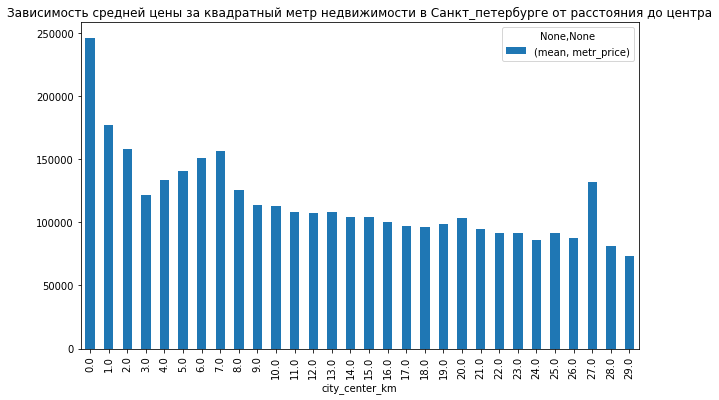

In [85]:
#гистограмма зависимости средней цены квадратного метра от удаленности от центра Санкт-Петербурга
(
    n.loc[n['locality_name'] == 'Санкт-Петербург', :]
    .pivot_table(index = 'city_center_km', values='metr_price', aggfunc = ['mean'])
    .plot(title='Зависимость средней цены за квадратный метр недвижимости в Санкт_петербурге от расстояния до центра', figsize=(10,6), kind='bar')
)

<AxesSubplot:title={'center':'Зависимость средней цены недвижимости в Санкт_петербурге от расстояния до центра'}, xlabel='city_center_km'>

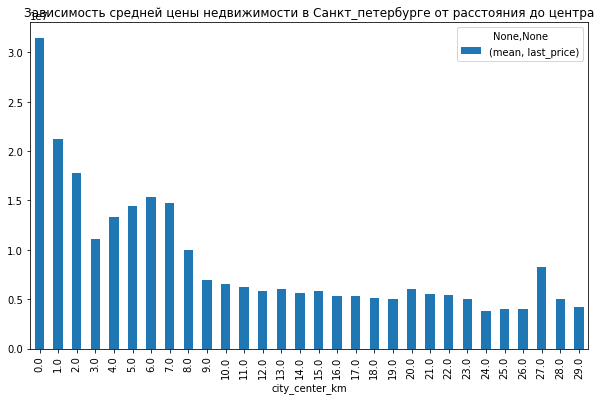

In [86]:
#гистограмма зависимости средней цены от удаленности от центра Санкт-Петербурга
(
    n.loc[n['locality_name'] == 'Санкт-Петербург', :]
    .pivot_table(index = 'city_center_km', values='last_price', aggfunc = ['mean'])
    .plot(title='Зависимость средней цены недвижимости в Санкт_петербурге от расстояния до центра', figsize=(10,6), kind='bar')
)

Чем ближе к центру, тем дороже... но не всегда. Исходя из диаграммы можно сделать вывод, что недвижимость на расстоянии 5-7 км и на расстоянии 27 км от центра продается с примерно такой же ценой за квадратный метр, что и квартиры в радиусе 1 км от центра города.

При этом объекты в центре наиболее дорогостоящие, возможно, это связано с тем, что в центре города достаточно много домов старой застройки, площади квартир в которых достаточно большие.


### Общий вывод

- были проанализированы 23699 записей с объявлениями о продаже квартир в Ленинградской области за период 2015 - 2019 гг. Чаще всего на сервисе публиковлись предложения о продаже объекта недвижимости за 3-4 миллиона, типичная площадь объекта - до 60м2.
- В ходе анализа было оценено распределение данных по различным параметрам. В результате было отмечено, что по некоторым параметрам (площадь кухни, расстояние до центра) гистограмма распределения имеет несколько пиков, что свидетельствует о смешении нескольких выборок в датасете. Было рекомендовано разделить выборку на несколько. Рекомендованные схемы разделения:
- квартира-студия или нет (в студиях либо нет кухни как помещения или же ее площадь минимальна);
- объекты недвижимости в Санкт-Петербурге и объекты недвижимости в Ленинградской области(не включая Санкт-Петербург)
Разделение выборок позволит в дальнейшем получить более точные результаты при анализе.

- При оценке параметров дат размещения объявлений было отмечено, что чаще всего объявления публикуются в четверг и вторник, в выходные число новых объявлений минимально. Также отмечается определенная сезонность. Меньше всего публикаций приходится на январь и май, в периоды с минимальным числом рабочих дней из всех месяцев в году. В целом, это коррелирует с результатами оценки распределения частоты публикаций по дням недели - на выходных авторы объявлений не заинтересованы в их оформлении, ведь праздники всегда снижают покупательскую способность, так как являются источниками дополнительных расходов, эмоционально захватывают потенциальных покупателей, также нет возможности оформить ипотеку, что также отрицательно влияет на процесс продажи.

- Максимально часто новые объявления появляются в феврале, марте и апреле. Данную тенденцию можно связать с общим оживлением рынка в данный период, сезоном премий во многих компаниях, которые являются стимулом покупателей для совершения сделки, из-за чего объявления не будут висеть долгое время.
- Второй пик приходится на осенний сезон, в который после летних отпусков начинает расти активность рынка. Также ряд участников рынка в осенний период меняют место жительства (смена работы после отпуска, начало учебы в другом городе), поэтому операции с недвижимостью вновь становятся популярными.

- Средняя длительность размещения составляла 180 дней, минимально объект недвижимости продавался за 1 день. При этом, чаще всего квартиры продавались за 45, 60 или 95 дней. При сроке размещения свыше 231 дня автору объявления следует оценить соответствие цены и качества объекта недвижимости, так как срок размещения объявления свыше 231 дня является достаточно долгим, и если покупатель до сих пор не нашелся, то возможно цена на объект завышена.

- Максимальное влияние на цену оказывают общая площадь квартиры, площадь жилой и кухонной зон, число комнат. Стоит отметить, что при определении стоимости минимально учитывается наличие рядом парков и прудов. Незначительно снижает цену удаленность аэропорта.

- Самые дешевые квартиры располагаются на первых этажах, больше всего готовы платить за квартиру не на первом и не на последнем этаже дома. День размещения объявления практически не влияет на итоговую стоимость квартиры, месяц размещения влияет незначительно.

- Максимальная стоимость квадратного метра по Ленинградской области и Санкт-Петербургу отмечается в Санкт-Петербурге, медианное значение стоимости также выше в Северной столице. При этом, разнообразие предложений позволяет найти в Санкт-Петербурге объект недвижимости с минимальной стоимостью за квадратный метр.

- Наиболее высокая цена за квадратный метр отмечается на расстоянии 0-1 км от центра Санкт-Петербурга (в этой окружности также располагаются самые дорогие объекты недвижимости), а также на расстоянии 5-7 км от центра.
